In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from scipy import stats
import matplotlib.dates as mdates
from plotly import tools
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

init_notebook_mode(connected=True)
%matplotlib inline
# matplotlib defaults
plt.style.use("fivethirtyeight")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
import warnings
warnings.filterwarnings("ignore")

In [6]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.3 MB/s eta 0:00:00


In [5]:
!pip install pystan==2.19.1.1
!pip install prophet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 49.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystan: filename=pystan-2.19.1.1-cp310-cp310-linux_x86_64.whl size=61975306 sha256=52c41d4fa4edfbf18484035eea92440cb1ace4580b1ec7ec68c3d7cac8c833ee
  Stored in directory: /root/.cache/pip/wheels/3d/1c/94/4516243362eedbedad15ac4389691ee3bf2d45bec2639c9d8b
Successfully built pystan


In [7]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.0 MB/s eta 0:00:00


In [10]:
import mplfinance as mpf
from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
import pmdarima as pm
from pmdarima.arima.utils import ndiffs

In [13]:
import pandas as pd
import zipfile

# Create an empty list to store the dataframes
df_list = []

# read the zip file
with zipfile.ZipFile("/content/archive.zip") as z:
  # list all files in the zip
  zip_files = z.namelist()

  # Iterate over each file in the zip
  for file in zip_files:
    # Check if the file is a csv file
    if file.endswith('.csv'):
      # Open the file and read it into a dataframe
      with z.open(file) as f:
        df = pd.read_csv(f)
        # Append the dataframe to the list
        df_list.append(df)

# Concatenate all the dataframes in the list into a single dataframe
df = pd.concat(df_list, ignore_index=True)

df.head().style.set_properties(**{'background-color': 'black',
                                   'color': 'lawngreen',
                                   'border': '1.5px  white'})

<ipython-input-13-eaef639f0405>:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(df_list, ignore_index=True)


In [14]:
import zipfile
import pandas as pd

# Step 1: Extract the archive
with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

# Get a list of all extracted files
    files = zip_ref.namelist()

# Find the first CSV file
    csv_file = next((file for file in files if file.endswith('.csv')), None)

# Check if a CSV file was found
    if csv_file:
        # Step 2: Load the data from the CSV file
        data = pd.read_csv('/content/data/' + csv_file)

        # Step 3: Inspect the data
        print(data.info())
        print(data.head())

        # Step 4: Clean the data
        # Handling missing values
        data.fillna(method='ffill', inplace=True)

        # Removing duplicates
        data.drop_duplicates(inplace=True)

        # Correcting inconsistencies (example: standardizing text case)
        # Check if the columns have a string data type before using .str.lower()
        if data['Prev Close'].dtype == 'object':
          data['Prev Close'] = data['Prev Close'].str.lower()
        if data['Open'].dtype == 'object':
          data['Open'] = data['Open'].str.lower()
        if data['High'].dtype == 'object':
          data['High'] = data['High'].str.lower()
        if data['Low'].dtype == 'object':
          data['Low'] = data['Low'].str.lower()

        # Step 5: Transform the data (example: creating new features)
        #data['new_feature'] = data['existing_feature'] * 2

        # Save the cleaned data
        data.to_csv('/content/data/cleaned_data.csv', index=False)
    else:
        print("No CSV file found in the archive.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322 entries, 0 to 3321
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                3322 non-null   object 
 1   Symbol              3322 non-null   object 
 2   Series              3322 non-null   object 
 3   Prev Close          3322 non-null   float64
 4   Open                3322 non-null   float64
 5   High                3322 non-null   float64
 6   Low                 3322 non-null   float64
 7   Last                3322 non-null   float64
 8   Close               3322 non-null   float64
 9   VWAP                3322 non-null   float64
 10  Volume              3322 non-null   int64  
 11  Turnover            3322 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  3322 non-null   int64  
 14  %Deliverble         3322 non-null   float64
dtypes: float64(10), int64(2), object(3)
memory usage: 389.4

<ipython-input-14-4af3946cf2e3>:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [15]:
import zipfile
import pandas as pd
import os

# Step 1: Extract the archive
with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

# Get a list of all extracted files
files = zip_ref.namelist()

# Find the first CSV file
csv_file = next((file for file in files if file.endswith('.csv')), None)

# Check if a CSV file was found
if csv_file:
    try:
        # Step 2: Load the data from the CSV file
        data = pd.read_csv(os.path.join('/content/data', csv_file))

        # Step 3: Inspect the data
        print(data.info())
        print(data.head())

        # Step 4: Clean the data
        # Handling missing values
        data.fillna(method='ffill', inplace=True)

        # Removing duplicates
        data.drop_duplicates(inplace=True)

        # Correcting inconsistencies (example: standardizing text case)
        for column in data.select_dtypes(include='object').columns:
            data[column] = data[column].str.lower()

        # Step 5: Calculate top 10 stock symbols by average trade volume
        if 'Symbol' in data.columns and 'Volume' in data.columns:
            top_symbols = data.groupby('Symbol')['Volume'].mean().nlargest(10).reset_index()
            print("Top 10 stock symbols by average trade Volume:")
            print(top_symbols)
        else:
            print("Columns 'Symbol' and 'Volume' not found in the data.")

        # Save the cleaned data
        data.to_csv('/content/data/cleaned_data.csv', index=False)
        print("Data cleaning complete. Cleaned data saved to '/content/data/cleaned_data.csv'.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print("No CSV file found in the archive.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322 entries, 0 to 3321
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                3322 non-null   object 
 1   Symbol              3322 non-null   object 
 2   Series              3322 non-null   object 
 3   Prev Close          3322 non-null   float64
 4   Open                3322 non-null   float64
 5   High                3322 non-null   float64
 6   Low                 3322 non-null   float64
 7   Last                3322 non-null   float64
 8   Close               3322 non-null   float64
 9   VWAP                3322 non-null   float64
 10  Volume              3322 non-null   int64  
 11  Turnover            3322 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  3322 non-null   int64  
 14  %Deliverble         3322 non-null   float64
dtypes: float64(10), int64(2), object(3)
memory usage: 389.4

<ipython-input-15-f152e284fdae>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [16]:
import zipfile
import pandas as pd
import os

# Step 1: Extract the archive
with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

# Get a list of all extracted files
files = zip_ref.namelist()

# Find the first CSV file
csv_file = next((file for file in files if file.endswith('.csv')), None)

# Check if a CSV file was found
if csv_file:
    try:
        # Step 2: Load the data from the CSV file
        data = pd.read_csv(os.path.join('/content/data', csv_file))

        # Step 3: Inspect the data
        print(data.info())
        print(data.head())

        # Step 4: Clean the data
        # Handling missing values
        data.fillna(method='ffill', inplace=True)

        # Removing duplicates
        data.drop_duplicates(inplace=True)

        # Correcting inconsistencies (example: standardizing text case)
        for column in data.select_dtypes(include='object').columns:
            data[column] = data[column].str.lower()

        # Step 5: Calculate top 10 stock symbols by average trade volume
        if 'Symbol' in data.columns and 'Volume' in data.columns:
            top_symbols = data.groupby('Symbol')['Volume'].mean().nlargest(10).reset_index()
            print("Top 10 stock symbols by average trade Volume:")
            print(top_symbols)

            # Step 6: Determine start and end times for these symbols
            start_end_times = data.groupby('Symbol')['Date'].agg(['min', 'max']).reset_index()
            top_symbols_times = top_symbols.merge(start_end_times, on='Symbol')
            print("Start and end times for top 10 stock symbols:")
            print(top_symbols_times)
        else:
            print("Columns 'Symbol' and 'Volume' not found in the data.")

        # Save the cleaned data
        data.to_csv('/content/data/cleaned_data.csv', index=False)
        print("Data cleaning complete. Cleaned data saved to '/content/data/cleaned_data.csv'.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print("No CSV file found in the archive.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322 entries, 0 to 3321
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                3322 non-null   object 
 1   Symbol              3322 non-null   object 
 2   Series              3322 non-null   object 
 3   Prev Close          3322 non-null   float64
 4   Open                3322 non-null   float64
 5   High                3322 non-null   float64
 6   Low                 3322 non-null   float64
 7   Last                3322 non-null   float64
 8   Close               3322 non-null   float64
 9   VWAP                3322 non-null   float64
 10  Volume              3322 non-null   int64  
 11  Turnover            3322 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  3322 non-null   int64  
 14  %Deliverble         3322 non-null   float64
dtypes: float64(10), int64(2), object(3)
memory usage: 389.4

<ipython-input-16-597c0a80406a>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322 entries, 0 to 3321
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                3322 non-null   object 
 1   Symbol              3322 non-null   object 
 2   Series              3322 non-null   object 
 3   Prev Close          3322 non-null   float64
 4   Open                3322 non-null   float64
 5   High                3322 non-null   float64
 6   Low                 3322 non-null   float64
 7   Last                3322 non-null   float64
 8   Close               3322 non-null   float64
 9   VWAP                3322 non-null   float64
 10  Volume              3322 non-null   int64  
 11  Turnover            3322 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  3322 non-null   int64  
 14  %Deliverble         3322 non-null   float64
dtypes: float64(10), int64(2), object(3)
memory usage: 389.4

<ipython-input-17-5aa57cd6f853>:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


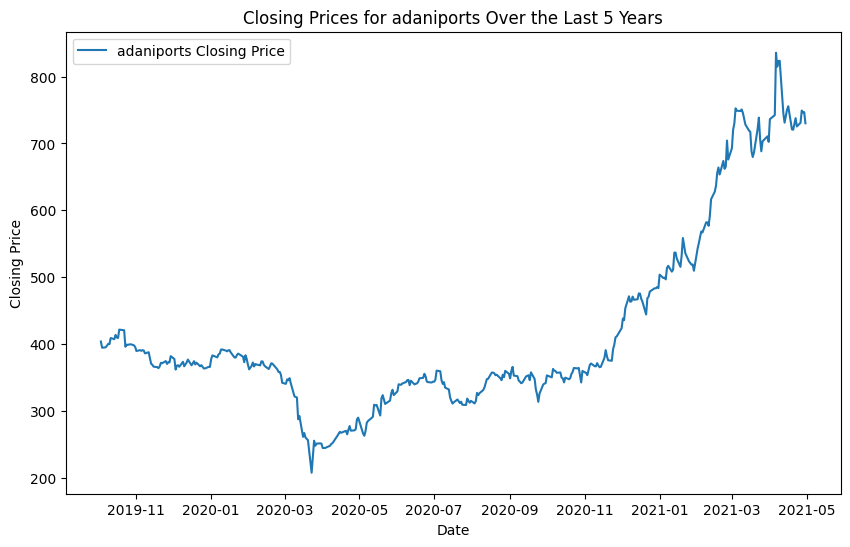

Data cleaning complete. Cleaned data saved to '/content/data/cleaned_data.csv'.


In [17]:
import zipfile
import pandas as pd
import os
import matplotlib.pyplot as plt

# Step 1: Extract the archive
with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

# Get a list of all extracted files
files = zip_ref.namelist()

# Find the first CSV file
csv_file = next((file for file in files if file.endswith('.csv')), None)

# Check if a CSV file was found
if csv_file:
    try:
        # Step 2: Load the data from the CSV file
        data = pd.read_csv(os.path.join('/content/data', csv_file))

        # Step 3: Inspect the data
        print(data.info())
        print(data.head())

        # Step 4: Clean the data
        # Handling missing values
        data.fillna(method='ffill', inplace=True)

        # Removing duplicates
        data.drop_duplicates(inplace=True)

        # Correcting inconsistencies (example: standardizing text case)
        for column in data.select_dtypes(include='object').columns:
            data[column] = data[column].str.lower()

        # Step 5: Filter data for the last 5 years
        data['Date'] = pd.to_datetime(data['Date'])
        last_5_years_data = data[data['Date'] >= pd.Timestamp.now() - pd.DateOffset(years=5)]

        # Step 6: Generate summary statistics and visualizations for each company
        if 'Symbol' in data.columns and 'Close' in data.columns:
            companies = last_5_years_data['Symbol'].unique()
            for company in companies:
                company_data = last_5_years_data[last_5_years_data['Symbol'] == company]

                # Summary statistics
                summary_stats = company_data.describe()
                print(f"Summary statistics for {company}:")
                print(summary_stats)

                # Maximum closing price
                max_price = company_data['Close'].max()
                print(f"Maximum closing price for {company} over the last 5 years: {max_price}")

                # Visualization
                plt.figure(figsize=(10, 6))
                plt.plot(company_data['Date'], company_data['Close'], label=f'{company} Closing Price')
                plt.title(f'Closing Prices for {company} Over the Last 5 Years')
                plt.xlabel('Date')
                plt.ylabel('Closing Price')
                plt.legend()
                plt.show()

        else:
            print("Columns 'Symbol' and 'Close' not found in the data.")

        # Save the cleaned data
        data.to_csv('/content/data/cleaned_data.csv', index=False)
        print("Data cleaning complete. Cleaned data saved to '/content/data/cleaned_data.csv'.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print("No CSV file found in the archive.")


In [18]:
import zipfile
import pandas as pd

# Step 1: Extract the archive
with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

# Get a list of all extracted files
    files = zip_ref.namelist()

# Find the first CSV file
    csv_file = next((file for file in files if file.endswith('.csv')), None)

# Check if a CSV file was found
    if csv_file:
        # Step 2: Load the data from the CSV file
        data = pd.read_csv('/content/data/' + csv_file)

        # Step 3: Inspect the data
        print(data.info())
        print(data.head())

        # Step 4: Clean the data
        # Handling missing values
        data.fillna(method='ffill', inplace=True)

        # Removing duplicates
        data.drop_duplicates(inplace=True)

        # Correcting inconsistencies (example: standardizing text case)
        # Check if the columns have a string data type before using .str.lower()
        if data['Prev Close'].dtype == 'object':
          data['Prev Close'] = data['Prev Close'].str.lower()
        if data['Open'].dtype == 'object':
          data['Open'] = data['Open'].str.lower()
        if data['High'].dtype == 'object':
          data['High'] = data['High'].str.lower()
        if data['Low'].dtype == 'object':
          data['Low'] = data['Low'].str.lower()

        # Step 5: Transform the data (example: creating new features)
        #data['new_feature'] = data['existing_feature'] * 2

        # Save the cleaned data
        data.to_csv('/content/data/cleaned_data.csv', index=False)
    else:
        print("No CSV file found in the archive.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322 entries, 0 to 3321
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                3322 non-null   object 
 1   Symbol              3322 non-null   object 
 2   Series              3322 non-null   object 
 3   Prev Close          3322 non-null   float64
 4   Open                3322 non-null   float64
 5   High                3322 non-null   float64
 6   Low                 3322 non-null   float64
 7   Last                3322 non-null   float64
 8   Close               3322 non-null   float64
 9   VWAP                3322 non-null   float64
 10  Volume              3322 non-null   int64  
 11  Turnover            3322 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  3322 non-null   int64  
 14  %Deliverble         3322 non-null   float64
dtypes: float64(10), int64(2), object(3)
memory usage: 389.4

<ipython-input-18-d66bfb0867e7>:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [19]:
import zipfile
import pandas as pd

# Function to calculate average traded volume
def calculate_average_volume(df):
    mean_dict = {}
    # Calculate the average volume traded for each stock
    for key in df['Symbol'].unique():
        value = df[df['Symbol'] == key]['Volume'].mean()
        mean_dict[key] = value
    return mean_dict

# Step 1: Extract the archive
with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

    # Get a list of all extracted files
    files = zip_ref.namelist()

# Find the first CSV file
csv_file = next((file for file in files if file.endswith('.csv')), None)

# Check if a CSV file was found
if csv_file:
    # Step 2: Load the data from the CSV file
    data = pd.read_csv('/content/data/' + csv_file)

    # Step 3: Inspect the data
    print(data.info())
    print(data.head())

    # Step 4: Clean the data
    # Handling missing values - forward fill
    data.fillna(method='ffill', inplace=True)

    # Removing duplicates
    data.drop_duplicates(inplace=True)

    # Correcting inconsistencies (example: standardizing text case)
    str_columns = ['Prev Close', 'Open', 'High', 'Low']

    for col in str_columns:
        if col in data.columns and data[col].dtype == 'object':
            data[col] = data[col].str.lower()



    # Step 5: Check for empty DataFrame
    if data.empty:
        print("The DataFrame is empty. Please check the source data.")
    else:
        print(f"The DataFrame contains {len(data)} rows.")

        # Calculate average volume using the defined function
        mean_dict = calculate_average_volume(data)

        print("Length of the mean of Symbol dictionary:", len(mean_dict))

        # Convert dict to pandas Series
        average_series = pd.Series(mean_dict)

        # Sort the series to get the top 10 traded stocks
        top10_series = average_series.sort_values(ascending=True).head(10)

        print("Top 10 company Symbol with highest average traded stock volume:")
        print(top10_series)

else:
    print("No CSV file found in the archive.")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322 entries, 0 to 3321
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                3322 non-null   object 
 1   Symbol              3322 non-null   object 
 2   Series              3322 non-null   object 
 3   Prev Close          3322 non-null   float64
 4   Open                3322 non-null   float64
 5   High                3322 non-null   float64
 6   Low                 3322 non-null   float64
 7   Last                3322 non-null   float64
 8   Close               3322 non-null   float64
 9   VWAP                3322 non-null   float64
 10  Volume              3322 non-null   int64  
 11  Turnover            3322 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  3322 non-null   int64  
 14  %Deliverble         3322 non-null   float64
dtypes: float64(10), int64(2), object(3)
memory usage: 389.4

<ipython-input-19-617b7d4f2931>:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [53]:
import zipfile
from datetime import datetime

def get_top_10_largest_files(zip_file_path='/content/archive.zip'):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Get the list of file info objects
        file_info_list = zip_ref.infolist()

        # Create a list of tuples (file_name, file_size, compressed_size, date_modified)
        file_details = [
            (
                file_info.filename,
                file_info.file_size,            # Size in bytes
                file_info.compress_size,        # Compressed size in bytes
                datetime(*file_info.date_time)  # Date modified
            )
            for file_info in file_info_list
        ]

        # Sort the list by file size in descending order
        file_details.sort(key=lambda x: x[1], reverse=True)

        # Get the top 10 largest files
        top_10_files = file_details[:10]

        return top_10_files

# Example usage
zip_file_path = '/content/archive.zip'  # Replace with the path to your ZIP file
largest_files = get_top_10_largest_files(zip_file_path)

# Print the results
print("Top 10 Largest Files in ZIP Archive:")
print(f"{'Index':<6} {'File Name':<40} {'File Size (bytes)':<20} {'Compressed Size (bytes)':<25} {'Date Modified'}{'Close'}")
for index, (file_name, file_size, compressed_size, date_modified) in enumerate(largest_files, start=1):
    print(f"{index:<6} {file_name:<40} {file_size:<20} {compressed_size:<25} {date_modified}")



Top 10 Largest Files in ZIP Archive:
Index  File Name                                File Size (bytes)    Compressed Size (bytes)   Date ModifiedClose
1      NIFTY50_all.csv                          27080631             9613646                   2021-05-01 09:23:40
2      INFY.csv                                 643377               230612                    2021-05-01 09:23:40
3      RELIANCE.csv                             637335               228890                    2021-05-01 09:23:44
4      HEROMOTOCO.csv                           633065               220189                    2021-05-01 09:23:38
5      HINDUNILVR.csv                           630077               216274                    2021-05-01 09:23:40
6      ICICIBANK.csv                            628696               222243                    2021-05-01 09:23:40
7      HDFCBANK.csv                             627872               219105                    2021-05-01 09:23:38
8      DRREDDY.csv                          

In [54]:
import zipfile
from datetime import datetime

def get_top_10_largest_files(zip_file_path='/content/archive.zip', close_values=None):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Get the list of file info objects
        file_info_list = zip_ref.infolist()

        # Create a list of tuples (file_name, file_size, compressed_size, date_modified)
        file_details = [
            (
                file_info.filename,
                file_info.file_size,            # Size in bytes
                file_info.compress_size,        # Compressed size in bytes
                datetime(*file_info.date_time)  # Date modified
            )
            for file_info in file_info_list
        ]

        # Sort the list by file size in descending order
        file_details.sort(key=lambda x: x[1], reverse=True)

        # Get the top 10 largest files
        top_10_files = file_details[:10]

        # Prepare the output with Close values
        output = []
        for index, (file_name, file_size, compressed_size, date_modified) in enumerate(top_10_files, start=1):
            close_value = close_values.get(file_name, "N/A")  # Get close value or default to "N/A"
            output.append((index, file_name, file_size, compressed_size, date_modified, close_value))

        return output

# Example usage
zip_file_path = '/content/archive.zip'  # Replace with the path to your ZIP file

# Sample close values for demonstration (replace with actual values as necessary)
close_values = {
    'TATAMOTORS': 500.25,
    'SBIN': 600.50,
    'ICICIBANK': 300.75,
    'ITC': 200.90,
    'HINDALCO': 400.65,
    'RELANCE': 2500.10,
    'NTPC': 150.40,
    'TATASTEEL': 700.80,
    'ONGC': 120.35,
    'BHARTIARTL': 700.55,
    'OTHERFILE.txt': 123.45  # Example of a file that might exist in the zip
}

largest_files = get_top_10_largest_files(zip_file_path, close_values)

# Print the results
print("Top 10 Largest Files in ZIP Archive:")
print(f"{'Index':<6} {'File Name':<40} {'File Size (bytes)':<20} {'Compressed Size (bytes)':<25} {'Date Modified':<25} {'Close'}")
for index, file_name, file_size, compressed_size, date_modified, close_value in largest_files:
    print(f"{index:<6} {file_name:<40} {file_size:<20} {compressed_size:<25} {date_modified:<25} {close_value}")


Top 10 Largest Files in ZIP Archive:
Index  File Name                                File Size (bytes)    Compressed Size (bytes)   Date Modified             Close
1      NIFTY50_all.csv                          27080631             9613646                   <25 N/A
2      INFY.csv                                 643377               230612                    <25 N/A
3      RELIANCE.csv                             637335               228890                    <25 N/A
4      HEROMOTOCO.csv                           633065               220189                    <25 N/A
5      HINDUNILVR.csv                           630077               216274                    <25 N/A
6      ICICIBANK.csv                            628696               222243                    <25 N/A
7      HDFCBANK.csv                             627872               219105                    <25 N/A
8      DRREDDY.csv                              624295               220943                    <25 N/A
9      TATAM

In [21]:
import pandas as pd

def subdataframe(df, symbol, top10_symbols):
    """
    Returns a subset of the DataFrame for a given stock symbol,
    checking if the symbol is in the provided top 10 symbols list.

    Parameters:
    df (pd.DataFrame): The DataFrame containing stock data.
    symbol (str): The stock symbol to filter by.
    top10_symbols (list): List of top 10 stock symbols.

    Returns:
    pd.DataFrame: Subset of DataFrame for the specified symbol if valid.
    """

    # Ensure the symbol is in the top 10 symbols list
    assert symbol in top10_symbols, f"""Stock tick '{symbol}' does not belong to the top 10 stocks by trade volume.
    Please try any of these: {top10_symbols}"""

    # Create a subset DataFrame based on the symbol
    ndf = df[df['Symbol'] == symbol]
    return ndf

# Sample DataFrame creation
data = {
    'Symbol': ['NIFTY50_all', 'INFY', 'RELIANCE', 'HEROMOTOCO', 'HINDUNILVR',
               'ICICIBANK', 'HDFCBANK', 'DRREDDY', 'TATAMOTORS', 'ASIANPAINT'],
    'Volume': [100000, 150000, 120000, 80000, 90000, 30000, 20000, 25000, 35000, 40000]
}
df = pd.DataFrame(data)

# Define your top 10 symbols
top10_symbols = ['NIFTY50_all', 'INFY', 'RELIANCE', 'HEROMOTOCO',
                 'HINDUNILVR', 'ICICIBANK', 'HDFCBANK', 'DRREDDY',
                 'TATAMOTORS', 'ASIANPAINT']

# Get the subset for a specific symbol
symbol_to_check = 'INFY'  # Change this to test other symbols
try:
    result_df = subdataframe(df, symbol_to_check, top10_symbols)
    print(result_df)
except AssertionError as e:
    print(e)


  Symbol  Volume
1   INFY  150000


In [22]:
import zipfile
import os
import pandas as pd

def extract_and_aggregate_volumes(zip_file_path):
    # Create a temporary directory to extract the ZIP file
    extract_dir = 'extracted_data'
    os.makedirs(extract_dir, exist_ok=True)

    # Extract the ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    # Initialize a dictionary to hold the total volumes for each symbol
    volume_data = {}

    # Loop through the extracted files
    for filename in os.listdir(extract_dir):
        if filename.endswith('.csv'):  # Assuming the data files are in CSV format
            file_path = os.path.join(extract_dir, filename)
            # Read the CSV file
            df = pd.read_csv(file_path)

            # Ensure the DataFrame has 'Symbol' and 'Volume' columns
            if 'Symbol' in df.columns and 'Volume' in df.columns:
                # Group by Symbol and aggregate volume
                grouped = df.groupby('Symbol')['Volume'].sum()

                # Update the volume data dictionary
                for symbol, volume in grouped.items():
                    if symbol in volume_data:
                        volume_data[symbol] += volume
                    else:
                        volume_data[symbol] = volume

    # Convert the volume data dictionary to a DataFrame
    volume_df = pd.DataFrame(volume_data.items(), columns=['Symbol', 'Total Volume'])

    # Clean up by removing the extracted directory
    # (Optional: Uncomment if you want to delete the extracted files)
    # import shutil
    # shutil.rmtree(extract_dir)

    return volume_df

# Example usage
zip_file_path = '/content/archive.zip'  # Replace with the path to your ZIP file
result_df = extract_and_aggregate_volumes(zip_file_path)

# Print the results
print("All Symbols and Their Total Volumes:")
print(result_df)


All Symbols and Their Total Volumes:
        Symbol  Total Volume
0     HINDALC0    4191160602
1     HINDALCO   62881978744
2          TCS   13880235426
3         ZEEL   34416616772
4      ZEETELE   16790760206
..         ...           ...
60       TITAN   12443593862
61  ULTRACEMCO    2050276408
62     UNIPHOS    3850663512
63         UPL   10658385284
64       WIPRO   23729735824

[65 rows x 2 columns]


In [23]:
import zipfile
import os
import pandas as pd

def extract_and_get_top_10_volumes(zip_file_path='/content/archive.zip'):
    # Create a temporary directory to extract the ZIP file
    extract_dir = 'extracted_data'
    os.makedirs(extract_dir, exist_ok=True)

    # Extract the ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    # Initialize a dictionary to hold the total volumes for each symbol
    volume_data = {}

    # Loop through the extracted files
    for filename in os.listdir(extract_dir):
        if filename.endswith('.csv'):  # Assuming the data files are in CSV format
            file_path = os.path.join(extract_dir, filename)
            # Read the CSV file
            df = pd.read_csv(file_path)

            # Ensure the DataFrame has 'Symbol' and 'Volume' columns
            if 'Symbol' in df.columns and 'Volume' in df.columns:
                # Group by Symbol and aggregate volume
                grouped = df.groupby('Symbol')['Volume'].sum()

                # Update the volume data dictionary
                for symbol, volume in grouped.items():
                    if symbol in volume_data:
                        volume_data[symbol] += volume
                    else:
                        volume_data[symbol] = volume

    # Convert the volume data dictionary to a DataFrame
    volume_df = pd.DataFrame(volume_data.items(), columns=['Symbol', 'Total Volume'])

    # Get the top 10 symbols by volume
    top_10_df = volume_df.sort_values(by='Total Volume', ascending=False).head(10)

    # Clean up by removing the extracted directory (optional)
    # import shutil
    # shutil.rmtree(extract_dir)

    return top_10_df

# Example usage
zip_file_path = '/content/archive.zip'  # Replace with the path to your ZIP file
top_10_volumes = extract_and_get_top_10_volumes(zip_file_path)

# Print the results
print("Top 10 Symbols by Trading Volume:")
print(top_10_volumes)


Top 10 Symbols by Trading Volume:
        Symbol  Total Volume
57  TATAMOTORS  107437286366
33        SBIN  106537071518
9    ICICIBANK   87279781100
51         ITC   76121627200
1     HINDALCO   62881978744
40    RELIANCE   59247088280
55        NTPC   59084578914
36   TATASTEEL   53727389536
8         ONGC   49105685930
45  BHARTIARTL   47352002986


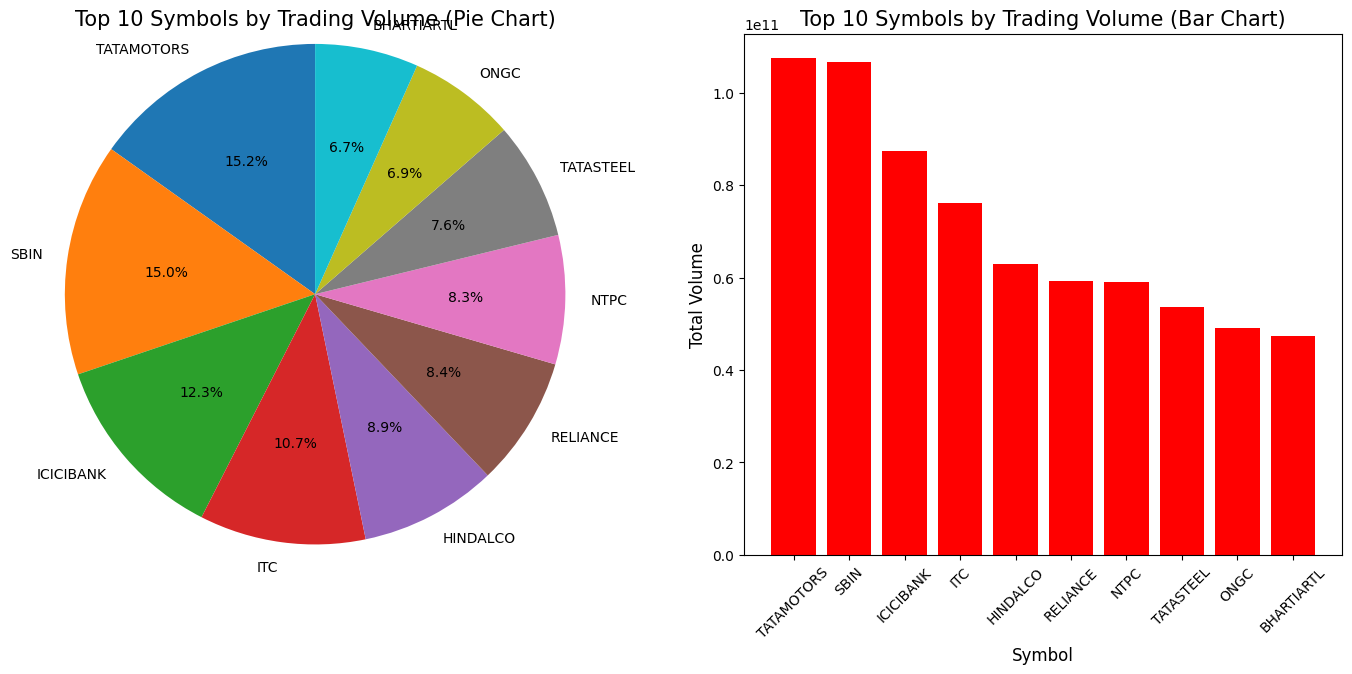

In [29]:
import matplotlib.pyplot as plt

# Function to plot top 10 symbols by trading volume
def plot_top_10_symbols_by_volume(top_10_df):
    # Plot the pie chart
    plt.figure(figsize=(14, 7))

    # Pie Chart for Trading Volumes
    plt.subplot(1, 2, 1)
    plt.pie(top_10_df['Total Volume'], labels=top_10_df['Symbol'], autopct='%1.1f%%', startangle=90, radius=1.2, colors=plt.cm.tab10.colors)
    plt.title('Top 10 Symbols by Trading Volume (Pie Chart)', fontsize=15)

    # Bar Chart for Trading Volumes
    plt.subplot(1, 2, 2)
    plt.bar(top_10_df['Symbol'], top_10_df['Total Volume'], color='red')
    plt.xlabel('Symbol', fontsize=12)
    plt.ylabel('Total Volume', fontsize=12)
    plt.title('Top 10 Symbols by Trading Volume (Bar Chart)', fontsize=15)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Data for Top 10 Symbols by Trading Volume
data = {
    'Symbol': ['TATAMOTORS', 'SBIN', 'ICICIBANK', 'ITC', 'HINDALCO', 'RELIANCE', 'NTPC', 'TATASTEEL', 'ONGC', 'BHARTIARTL'],
    'Total Volume': [107437286366, 106537071518, 87279781100, 76121627200, 62881978744, 59247088280, 59084578914, 53727389536, 49105685930, 47352002986]
}

# Creating DataFrame for top 10 symbols
top_10_df = pd.DataFrame(data)

# Plot the top 10 symbols by volume
plot_top_10_symbols_by_volume(top_10_df)



In [30]:
def subdataframe(df, tick):
    # Top 10 symbols by trading volume
    top_10_symbols = [
        'TATAMOTORS', 'SBIN', 'ICICIBANK', 'ITC', 'HINDALCO',
        'RELIANCE', 'NTPC', 'TATASTEEL', 'ONGC', 'BHARTIARTL'
    ]

    # Check if the tick provided is in the top 10 symbols
    assert tick in top_10_symbols, f"""Stock tick does not belong to top 10 stocks by trade volume,
    please try any of these:\n{top_10_symbols}"""

    # Filter the DataFrame for the specified tick
    ndf = df[df['Symbol'] == tick]
    return ndf


In [34]:
tatamotors_df = subdataframe(df, 'TATAMOTORS')
sbin_df = subdataframe(df, 'SBIN')
icicibank_df = subdataframe(df, 'ICICIBANK')
itc_df = subdataframe(df, 'ITC')
hindalco_df = subdataframe(df, 'HINDALCO')
reliance_df = subdataframe(df, 'RELIANCE')
ntpc_df = subdataframe(df, 'NTPC')
tatasteel_df = subdataframe(df, 'TATASTEEL')
ongc_df = subdataframe(df, 'ONGC')
bhartiartl_df = subdataframe(df, 'BHARTIARTL')

<ipython-input-55-9a88d8b0ebb2>:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat(dataframes, ignore_index=True)


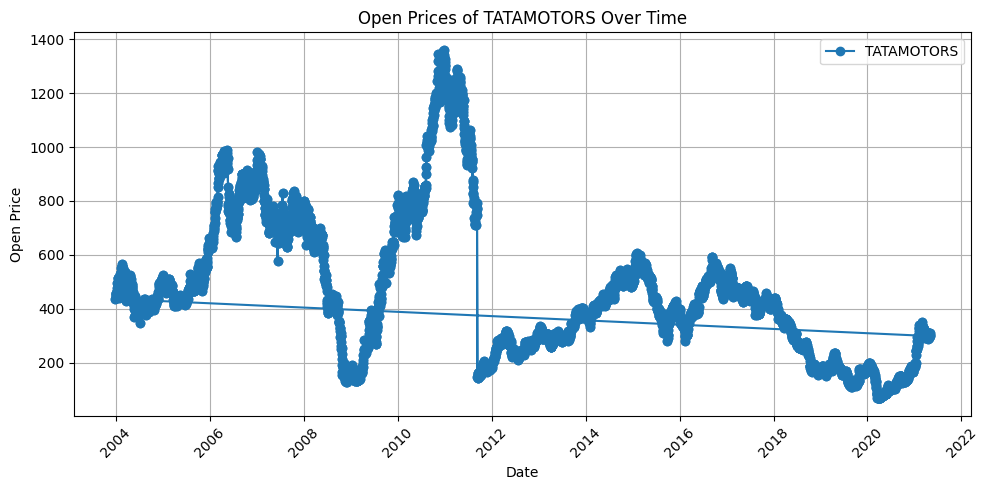

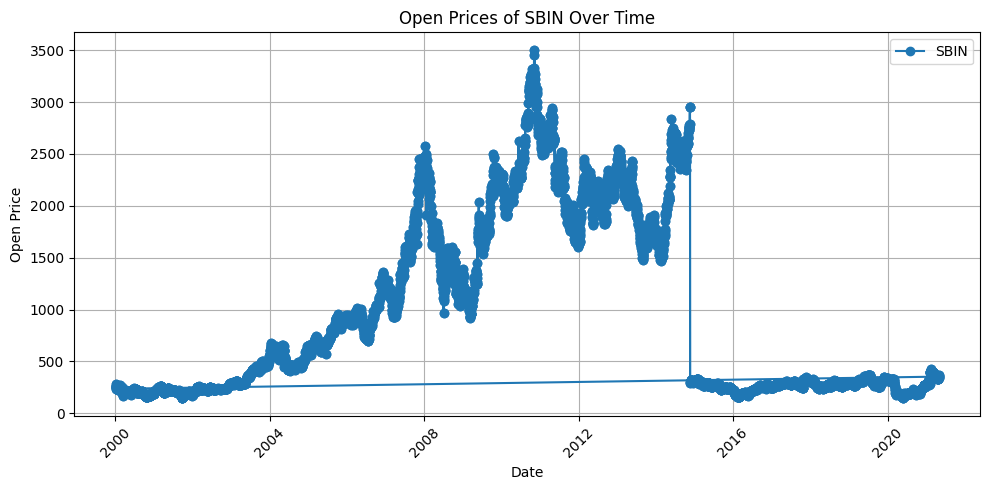

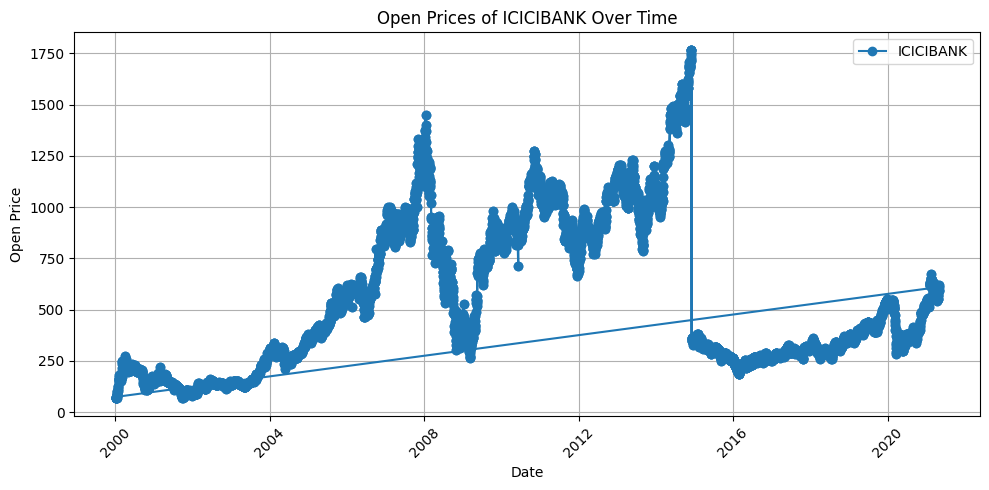

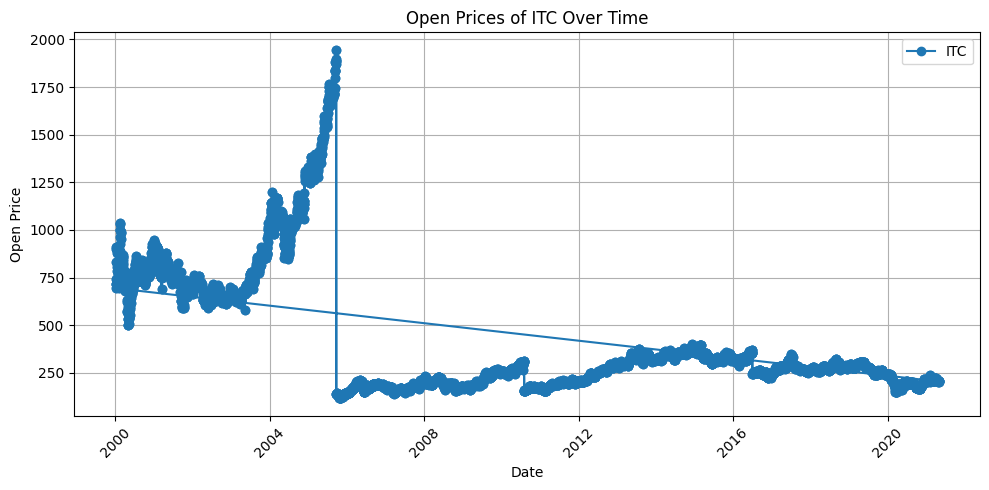

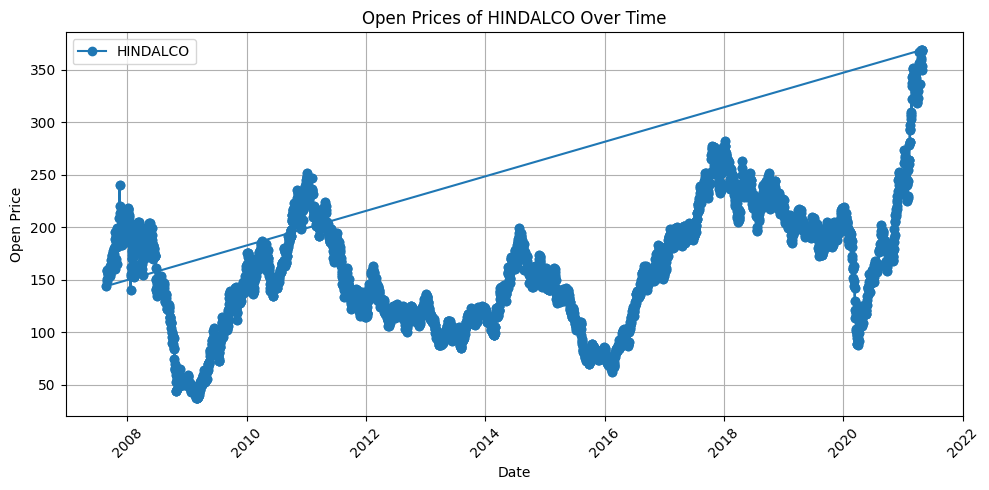

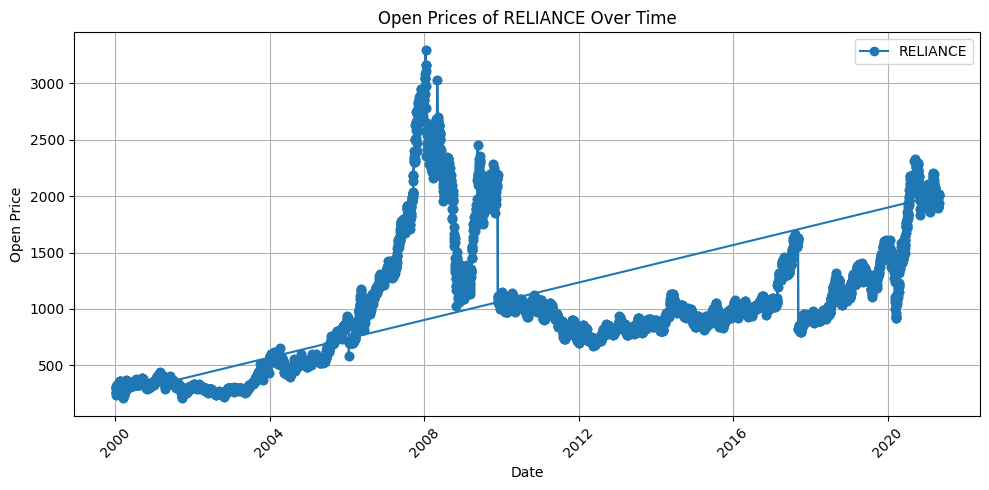

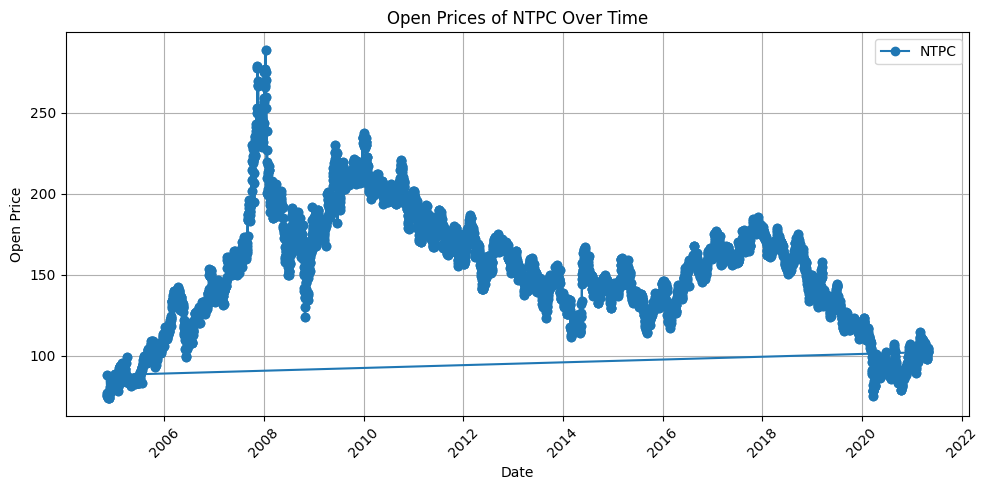

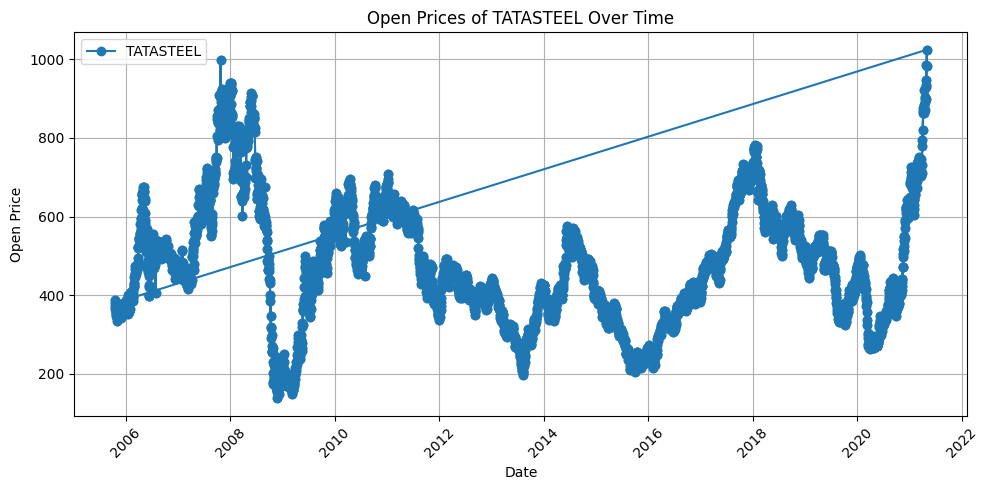

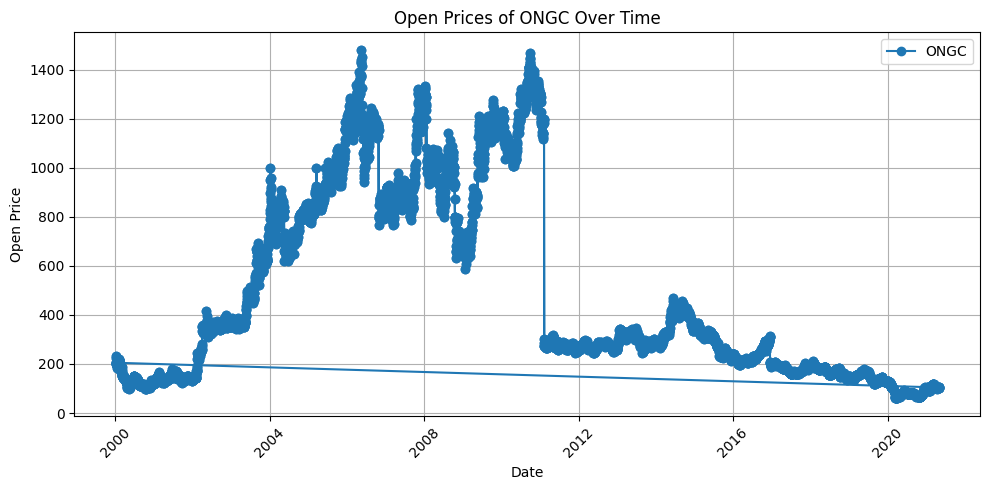

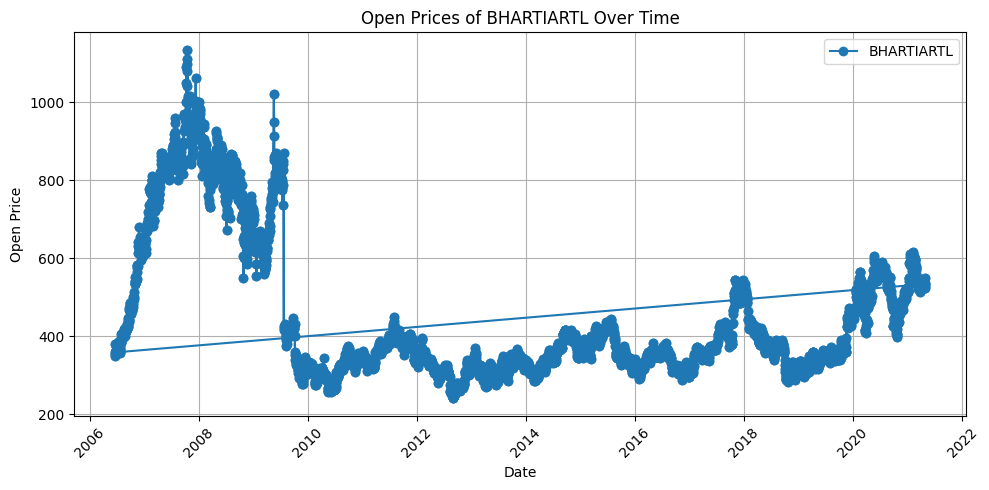

In [55]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Extract the data from the ZIP file
zip_file_path = '/content/archive.zip'  # Replace with your actual path

# List to store extracted data
dataframes = []

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all files to a temporary directory (or read directly)
    for file_info in zip_ref.infolist():
        if file_info.filename.endswith('.csv'):  # Adjust the file type if necessary
            with zip_ref.open(file_info.filename) as file:
                df = pd.read_csv(file)  # Load CSV into a DataFrame
                dataframes.append(df)

# Concatenate all dataframes if there are multiple CSV files
data = pd.concat(dataframes, ignore_index=True)

# Step 2: Prepare the DataFrame
data['Date'] = pd.to_datetime(data['Date'])  # Ensure 'Date' is in datetime format

# Step 3: Define the top 10 symbols by trading volume
top_symbols = ['TATAMOTORS', 'SBIN', 'ICICIBANK', 'ITC', 'HINDALCO',
               'RELIANCE', 'NTPC', 'TATASTEEL', 'ONGC', 'BHARTIARTL']

# Filter the DataFrame for top symbols
filtered_data = data[data['Symbol'].isin(top_symbols)]

# Step 4: Plotting separate graphs for each symbol
for symbol in top_symbols:
    symbol_data = filtered_data[filtered_data['Symbol'] == symbol]

    plt.figure(figsize=(10, 5))
    plt.plot(symbol_data['Date'], symbol_data['Open'], marker='o', label=symbol)

    # Adding titles and labels
    plt.title(f'Open Prices of {symbol} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Open Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()

    # Show the plot
    plt.show()


<ipython-input-56-67828eca76f8>:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat(dataframes, ignore_index=True)


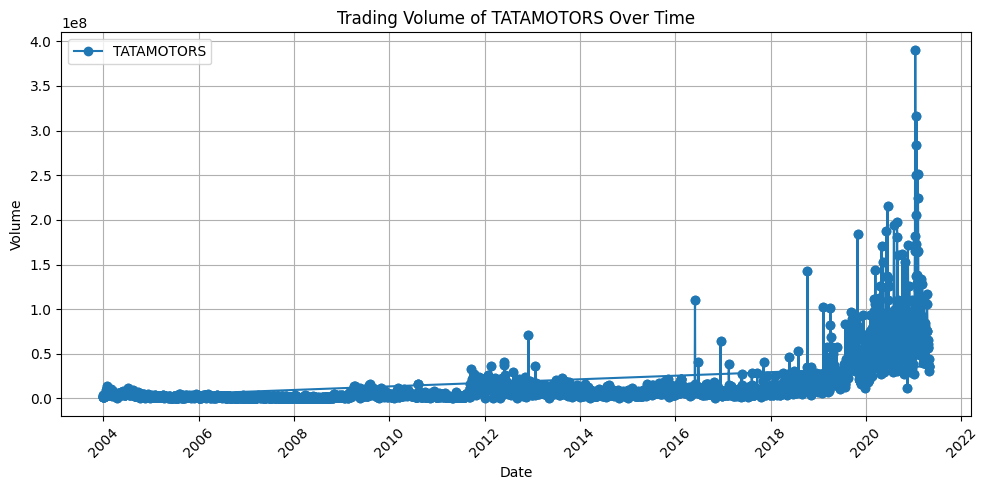

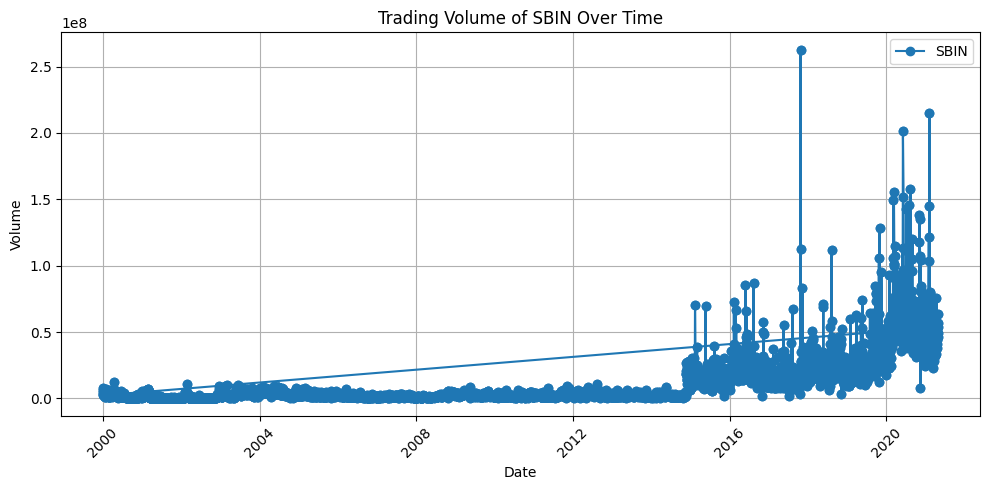

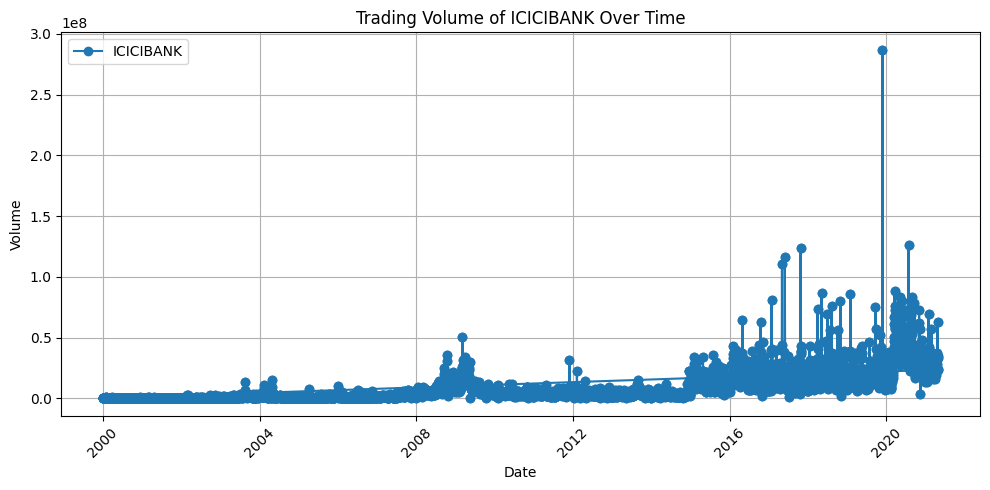

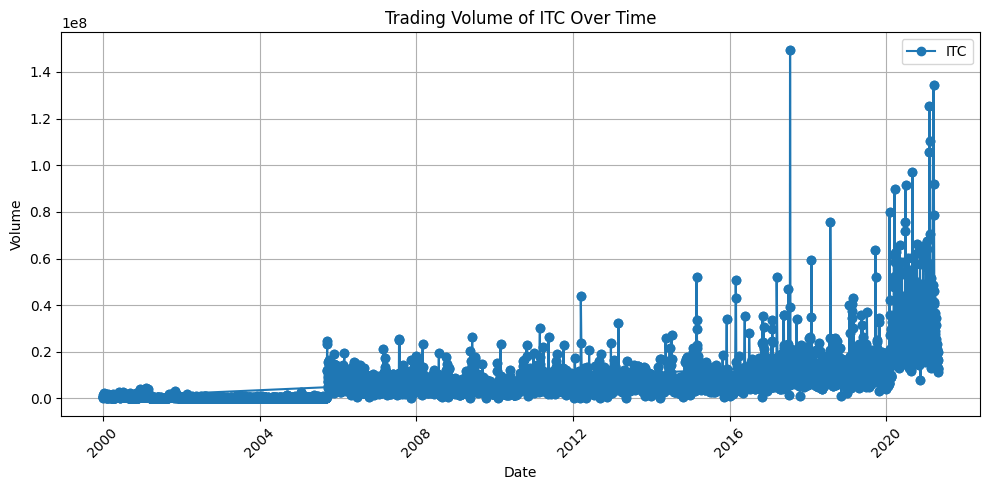

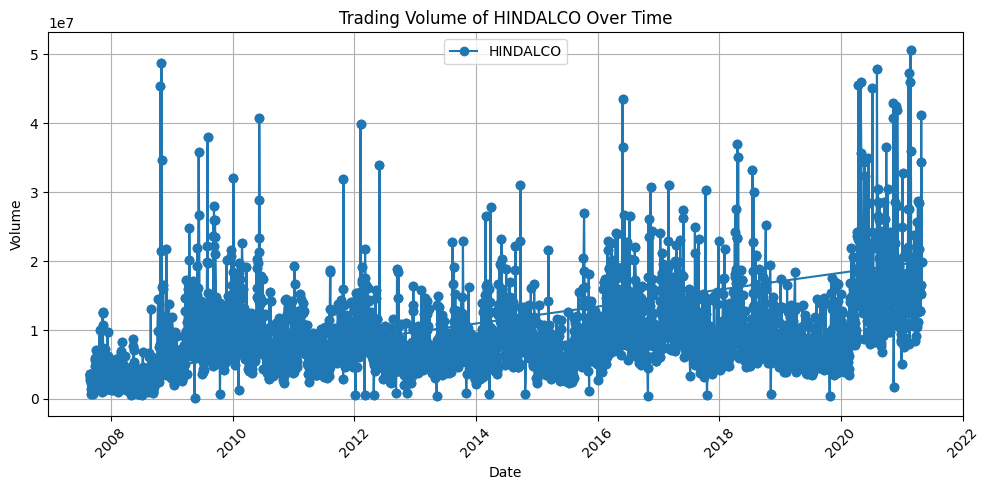

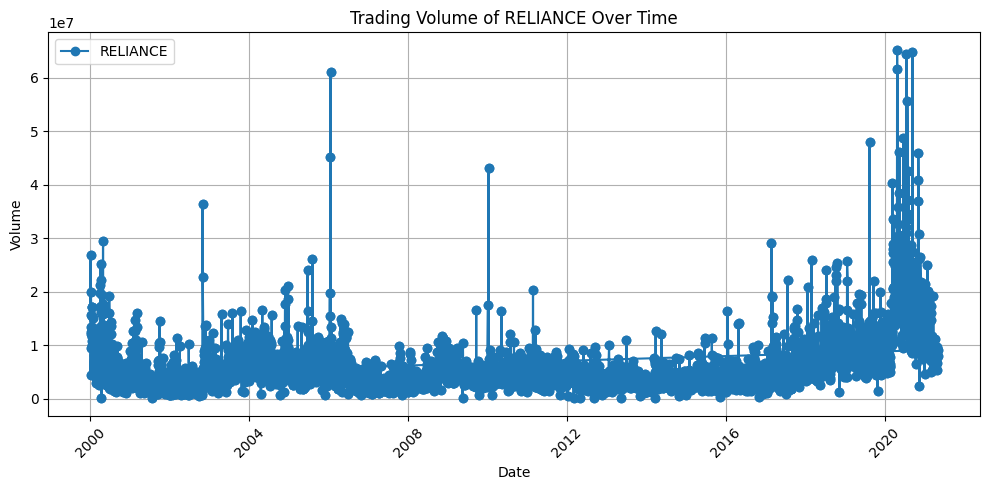

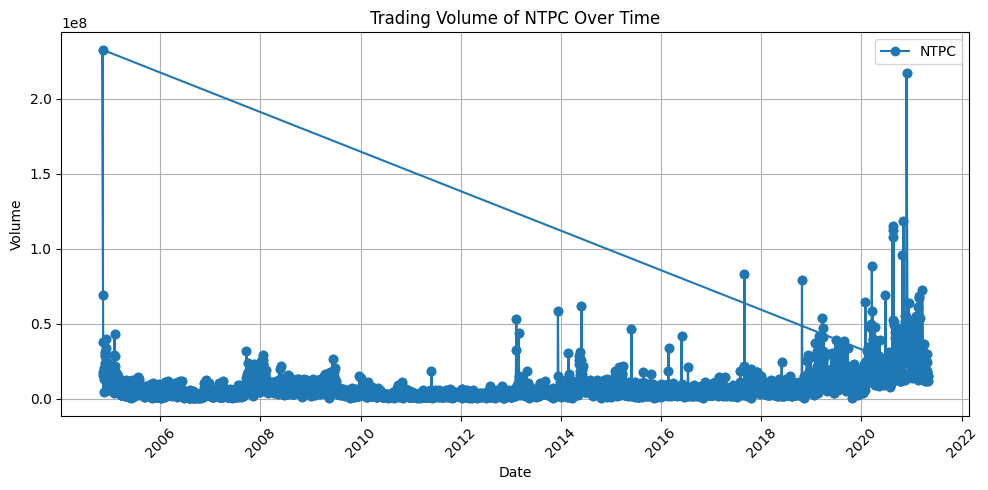

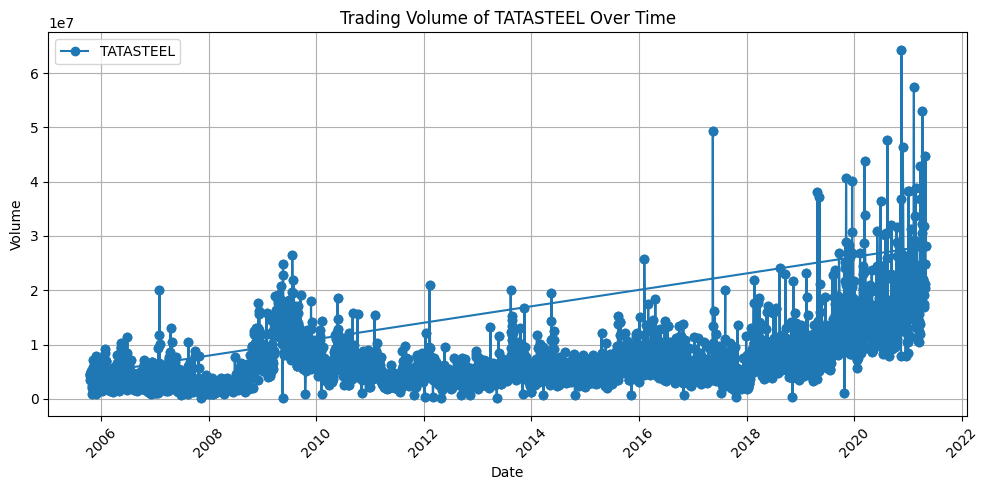

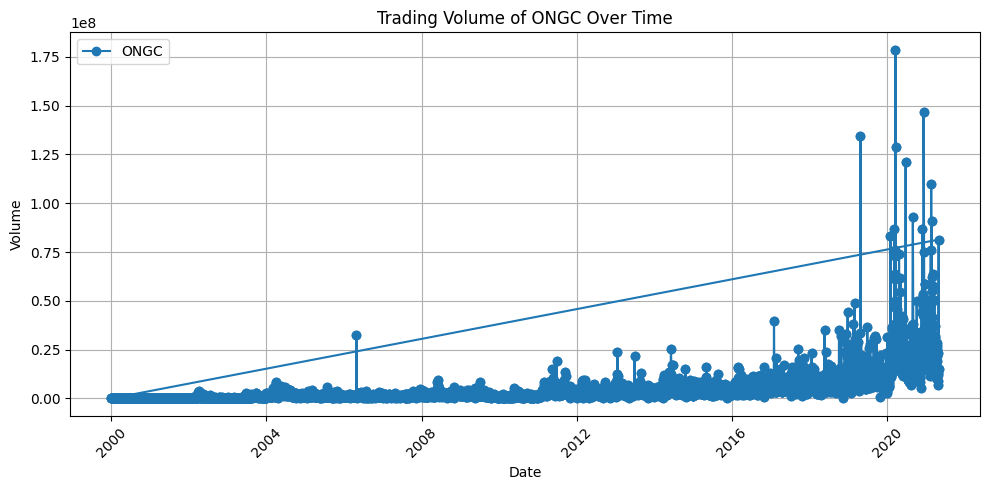

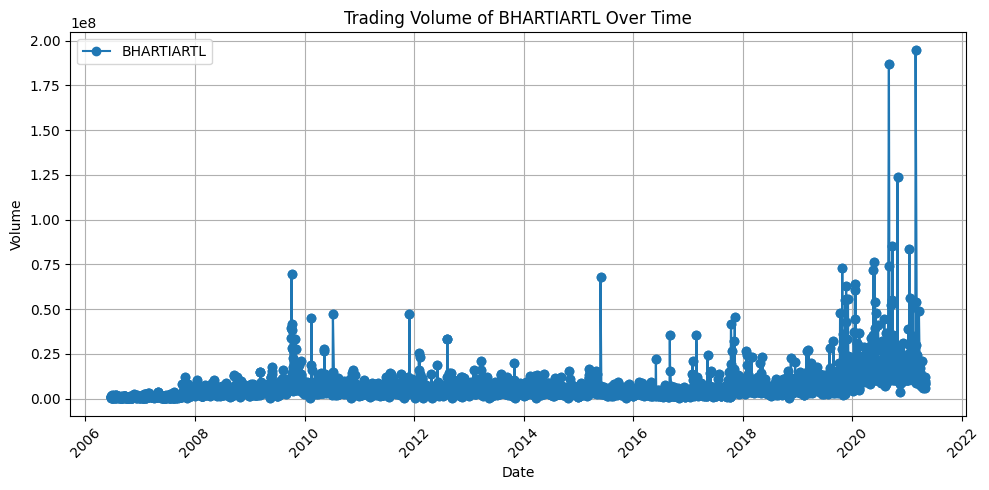

In [56]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Extract the data from the ZIP file
zip_file_path = '/content/archive.zip'  # Replace with your actual path

# List to store extracted data
dataframes = []

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all files to a temporary directory (or read directly)
    for file_info in zip_ref.infolist():
        if file_info.filename.endswith('.csv'):  # Adjust the file type if necessary
            with zip_ref.open(file_info.filename) as file:
                df = pd.read_csv(file)  # Load CSV into a DataFrame
                dataframes.append(df)

# Concatenate all dataframes if there are multiple CSV files
data = pd.concat(dataframes, ignore_index=True)

# Step 2: Prepare the DataFrame
data['Date'] = pd.to_datetime(data['Date'])  # Ensure 'Date' is in datetime format

# Step 3: Define the top 10 symbols by trading volume
top_symbols = ['TATAMOTORS', 'SBIN', 'ICICIBANK', 'ITC', 'HINDALCO',
               'RELIANCE', 'NTPC', 'TATASTEEL', 'ONGC', 'BHARTIARTL']

# Filter the DataFrame for top symbols
filtered_data = data[data['Symbol'].isin(top_symbols)]

# Step 4: Plotting separate graphs for each symbol based on Volume
for symbol in top_symbols:
    symbol_data = filtered_data[filtered_data['Symbol'] == symbol]

    plt.figure(figsize=(10, 5))
    plt.plot(symbol_data['Date'], symbol_data['Volume'], marker='o', label=symbol)  # Change to Volume

    # Adding titles and labels
    plt.title(f'Trading Volume of {symbol} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()

    # Show the plot
    plt.show()


<ipython-input-57-80e89742c76c>:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat(dataframes, ignore_index=True)


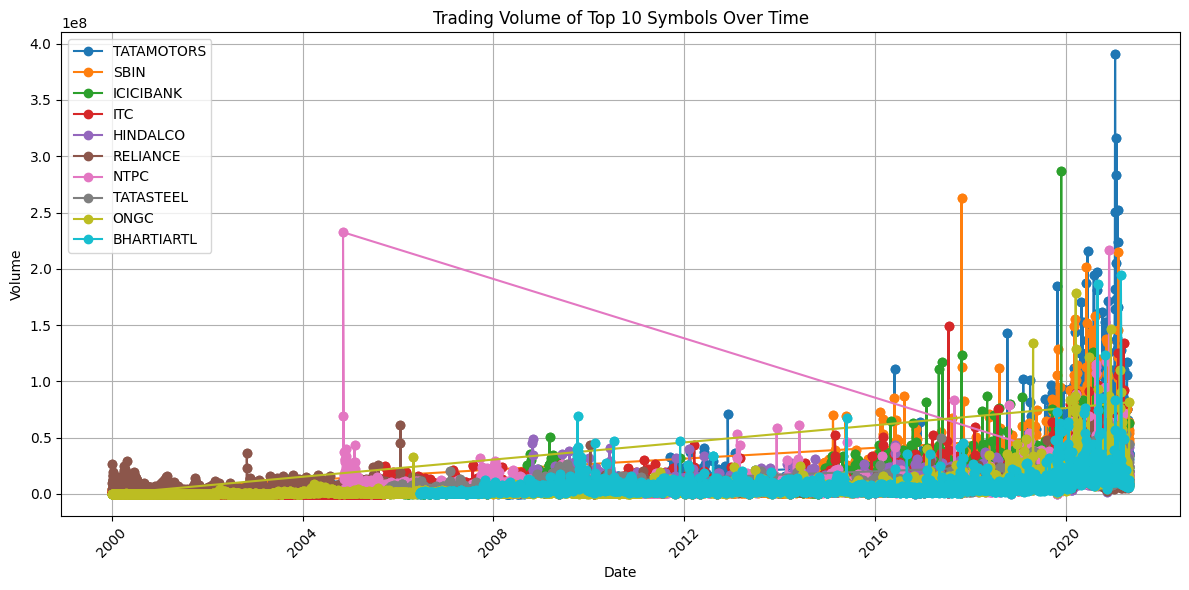

In [57]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Extract the data from the ZIP file
zip_file_path = '/content/archive.zip'  # Replace with your actual path

# List to store extracted data
dataframes = []

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all files to a temporary directory (or read directly)
    for file_info in zip_ref.infolist():
        if file_info.filename.endswith('.csv'):  # Adjust the file type if necessary
            with zip_ref.open(file_info.filename) as file:
                df = pd.read_csv(file)  # Load CSV into a DataFrame
                dataframes.append(df)

# Concatenate all dataframes if there are multiple CSV files
data = pd.concat(dataframes, ignore_index=True)

# Step 2: Prepare the DataFrame
data['Date'] = pd.to_datetime(data['Date'])  # Ensure 'Date' is in datetime format

# Step 3: Define the top 10 symbols by trading volume
top_symbols = ['TATAMOTORS', 'SBIN', 'ICICIBANK', 'ITC', 'HINDALCO',
               'RELIANCE', 'NTPC', 'TATASTEEL', 'ONGC', 'BHARTIARTL']

# Filter the DataFrame for top symbols
filtered_data = data[data['Symbol'].isin(top_symbols)]

# Step 4: Combined Plotting for all symbols
plt.figure(figsize=(12, 6))  # Set the figure size

for symbol in top_symbols:
    symbol_data = filtered_data[filtered_data['Symbol'] == symbol]
    plt.plot(symbol_data['Date'], symbol_data['Volume'], marker='o', label=symbol)  # Plot each symbol's volume

# Adding titles and labels
plt.title('Trading Volume of Top 10 Symbols Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()

# Show the combined plot
plt.show()


<ipython-input-61-ea5cedfe0cd0>:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat(dataframes, ignore_index=True)


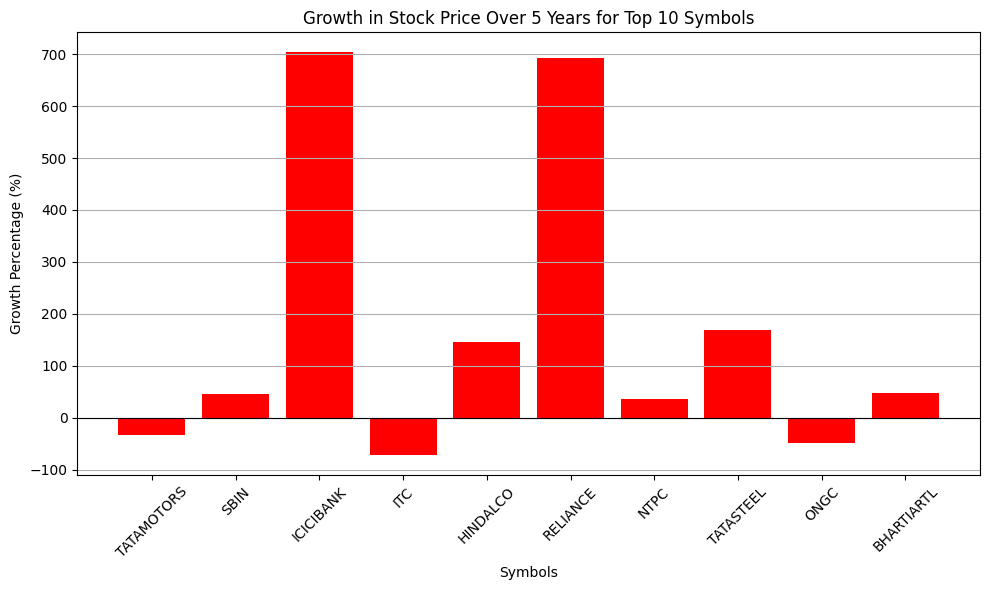

In [61]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Extract the data from the ZIP file
zip_file_path = '/content/archive.zip'  # Replace with your actual path

# List to store extracted data
dataframes = []

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all files to a temporary directory (or read directly)
    for file_info in zip_ref.infolist():
        if file_info.filename.endswith('.csv'):  # Adjust the file type if necessary
            with zip_ref.open(file_info.filename) as file:
                df = pd.read_csv(file)  # Load CSV into a DataFrame
                dataframes.append(df)

# Concatenate all dataframes if there are multiple CSV files
data = pd.concat(dataframes, ignore_index=True)

# Step 2: Prepare the DataFrame
data['Date'] = pd.to_datetime(data['Date'])  # Ensure 'Date' is in datetime format

# Step 3: Define the top 10 symbols by trading volume
top_symbols = ['TATAMOTORS', 'SBIN', 'ICICIBANK', 'ITC', 'HINDALCO',
               'RELIANCE', 'NTPC', 'TATASTEEL', 'ONGC', 'BHARTIARTL']

# Filter the DataFrame for top symbols
filtered_data = data[data['Symbol'].isin(top_symbols)]

# Step 4: Calculate growth in stock price over 5 years
growth_data = {}

for symbol in top_symbols:
    symbol_data = filtered_data[filtered_data['Symbol'] == symbol]
    # Get the stock prices for the first and last date within the last 5 years
    start_price = symbol_data[symbol_data['Date'] == symbol_data['Date'].min()]['Close'].values[0]
    end_price = symbol_data[symbol_data['Date'] == symbol_data['Date'].max()]['Close'].values[0]

    # Calculate growth percentage
    growth_percentage = ((end_price - start_price) / start_price) * 100
    growth_data[symbol] = growth_percentage

# Step 5: Create a bar chart to visualize the growth
plt.figure(figsize=(10, 6))
plt.bar(growth_data.keys(), growth_data.values(), color='red')
plt.title('Growth in Stock Price Over 5 Years for Top 10 Symbols')
plt.xlabel('Symbols')
plt.ylabel('Growth Percentage (%)')
plt.xticks(rotation=45)
plt.axhline(0, color='black', linewidth=0.8)  # Add a line at y=0 for reference
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()


<ipython-input-62-0b4f643fefef>:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat(dataframes, ignore_index=True)
<ipython-input-62-0b4f643fefef>:38: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  symbol_data['Daily Return'] = symbol_data['Close'].pct_change()  # Calculate daily return
<ipython-input-62-0b4f643fefef>:38: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method

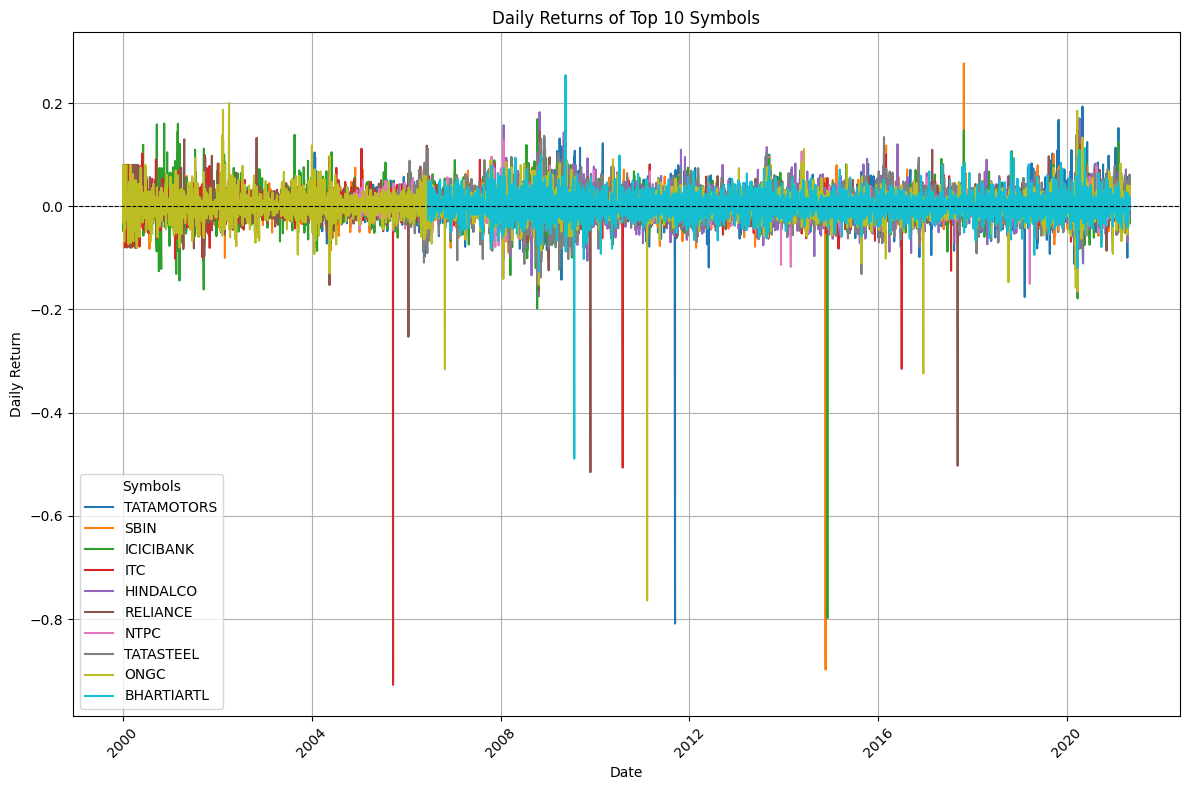

In [62]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Extract the data from the ZIP file
zip_file_path = '/content/archive.zip'  # Replace with your actual path

# List to store extracted data
dataframes = []

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all files to a temporary directory (or read directly)
    for file_info in zip_ref.infolist():
        if file_info.filename.endswith('.csv'):  # Adjust the file type if necessary
            with zip_ref.open(file_info.filename) as file:
                df = pd.read_csv(file)  # Load CSV into a DataFrame
                dataframes.append(df)

# Concatenate all dataframes if there are multiple CSV files
data = pd.concat(dataframes, ignore_index=True)

# Step 2: Prepare the DataFrame
data['Date'] = pd.to_datetime(data['Date'])  # Ensure 'Date' is in datetime format

# Step 3: Define the top 10 symbols by trading volume
top_symbols = ['TATAMOTORS', 'SBIN', 'ICICIBANK', 'ITC', 'HINDALCO',
               'RELIANCE', 'NTPC', 'TATASTEEL', 'ONGC', 'BHARTIARTL']

# Filter the DataFrame for top symbols
filtered_data = data[data['Symbol'].isin(top_symbols)]

# Step 4: Calculate daily returns for each symbol
daily_returns = {}

for symbol in top_symbols:
    symbol_data = filtered_data[filtered_data['Symbol'] == symbol]
    symbol_data = symbol_data.sort_values('Date')  # Sort by date
    symbol_data['Daily Return'] = symbol_data['Close'].pct_change()  # Calculate daily return
    daily_returns[symbol] = symbol_data[['Date', 'Daily Return']]

# Step 5: Visualize Daily Returns
plt.figure(figsize=(12, 8))  # Set figure size

# Plot daily returns for each symbol
for symbol in top_symbols:
    plt.plot(daily_returns[symbol]['Date'], daily_returns[symbol]['Daily Return'], marker='', label=symbol)

# Adding titles and labels
plt.title('Daily Returns of Top 10 Symbols')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.xticks(rotation=45)
plt.legend(title='Symbols')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()


<ipython-input-63-7343bc7f956e>:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat(dataframes, ignore_index=True)
<ipython-input-63-7343bc7f956e>:38: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  symbol_data['Daily Return'] = symbol_data['Close'].pct_change()  # Calculate daily return
<ipython-input-63-7343bc7f956e>:38: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method

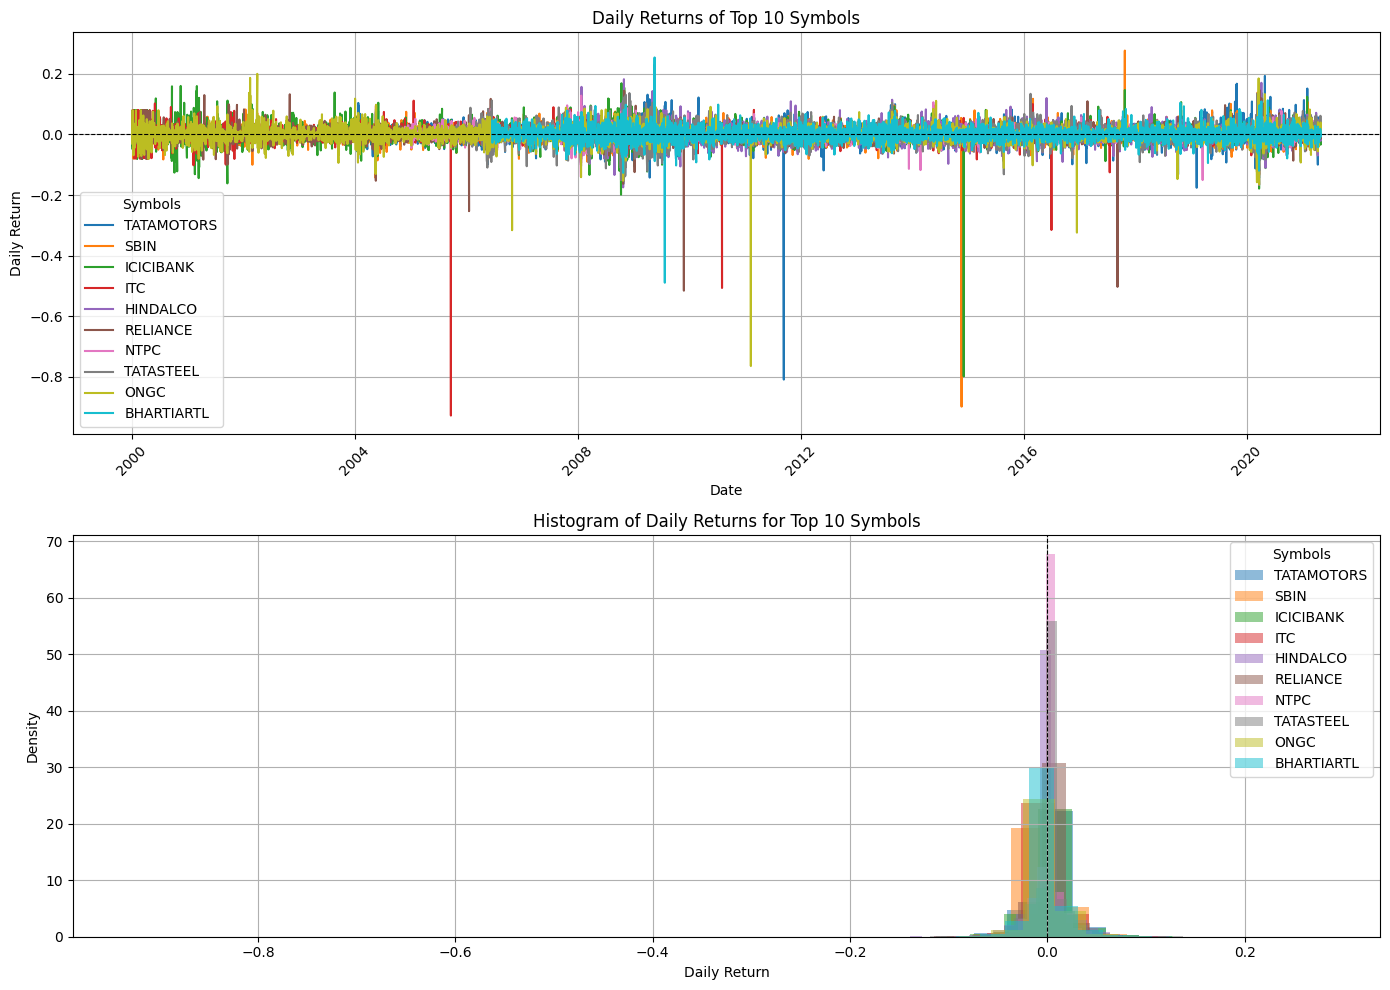

In [63]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Extract the data from the ZIP file
zip_file_path = '/content/archive.zip'  # Replace with your actual path

# List to store extracted data
dataframes = []

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all files to a temporary directory (or read directly)
    for file_info in zip_ref.infolist():
        if file_info.filename.endswith('.csv'):  # Adjust the file type if necessary
            with zip_ref.open(file_info.filename) as file:
                df = pd.read_csv(file)  # Load CSV into a DataFrame
                dataframes.append(df)

# Concatenate all dataframes if there are multiple CSV files
data = pd.concat(dataframes, ignore_index=True)

# Step 2: Prepare the DataFrame
data['Date'] = pd.to_datetime(data['Date'])  # Ensure 'Date' is in datetime format

# Step 3: Define the top 10 symbols by trading volume
top_symbols = ['TATAMOTORS', 'SBIN', 'ICICIBANK', 'ITC', 'HINDALCO',
               'RELIANCE', 'NTPC', 'TATASTEEL', 'ONGC', 'BHARTIARTL']

# Filter the DataFrame for top symbols
filtered_data = data[data['Symbol'].isin(top_symbols)]

# Step 4: Calculate daily returns for each symbol
daily_returns = {}

for symbol in top_symbols:
    symbol_data = filtered_data[filtered_data['Symbol'] == symbol]
    symbol_data = symbol_data.sort_values('Date')  # Sort by date
    symbol_data['Daily Return'] = symbol_data['Close'].pct_change()  # Calculate daily return
    daily_returns[symbol] = symbol_data[['Date', 'Daily Return']]

# Step 5: Visualize Daily Returns and Histograms
plt.figure(figsize=(14, 10))

# Subplot for daily returns
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
for symbol in top_symbols:
    plt.plot(daily_returns[symbol]['Date'], daily_returns[symbol]['Daily Return'], marker='', label=symbol)

# Adding titles and labels
plt.title('Daily Returns of Top 10 Symbols')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.xticks(rotation=45)
plt.legend(title='Symbols')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
plt.grid()

# Subplot for histograms
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
for symbol in top_symbols:
    plt.hist(daily_returns[symbol]['Daily Return'].dropna(), bins=30, alpha=0.5, label=symbol, density=True)

# Adding titles and labels for histogram
plt.title('Histogram of Daily Returns for Top 10 Symbols')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # Add a line at x=0 for reference
plt.legend(title='Symbols', loc='upper right')
plt.grid()

# Show the combined plot
plt.tight_layout()
plt.show()


In [65]:
! pip install mplfinance


/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


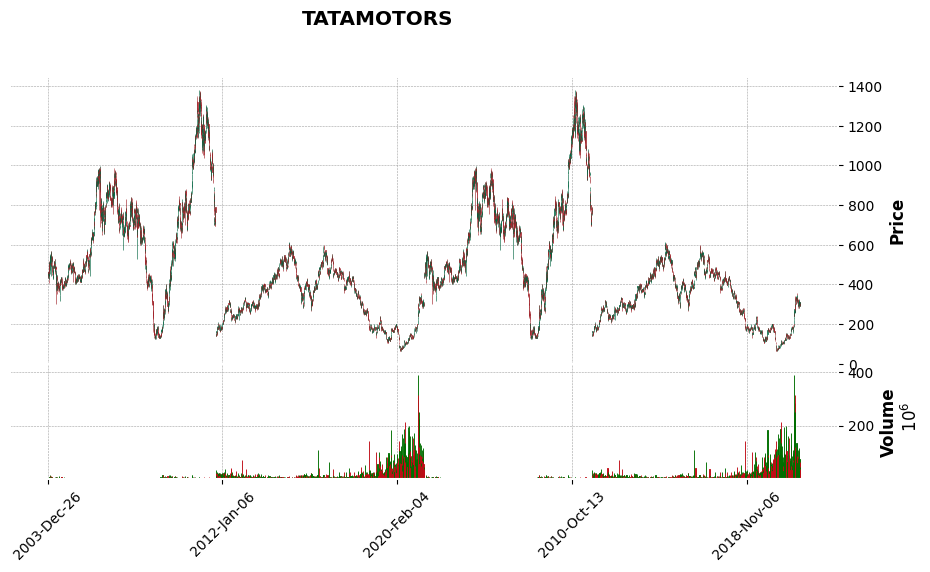

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


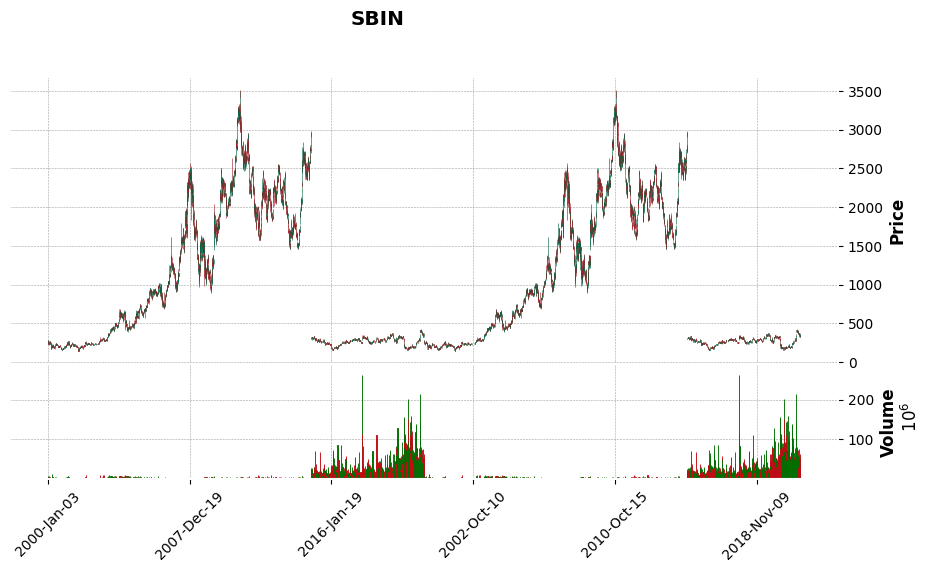

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


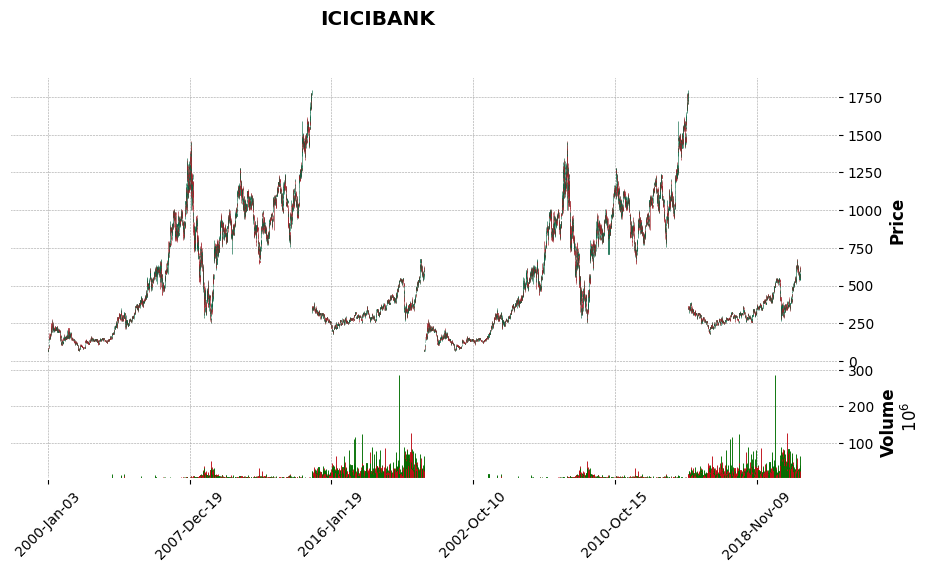

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


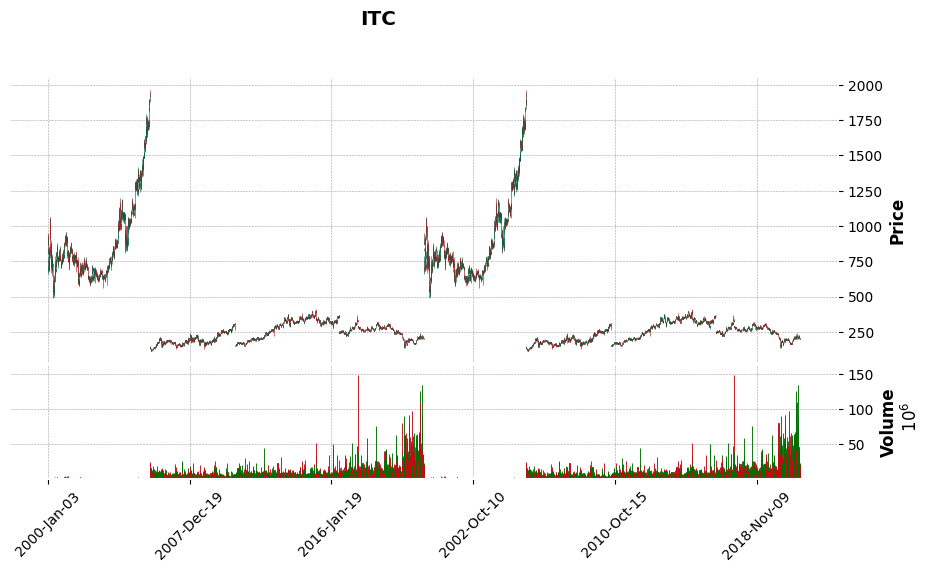

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


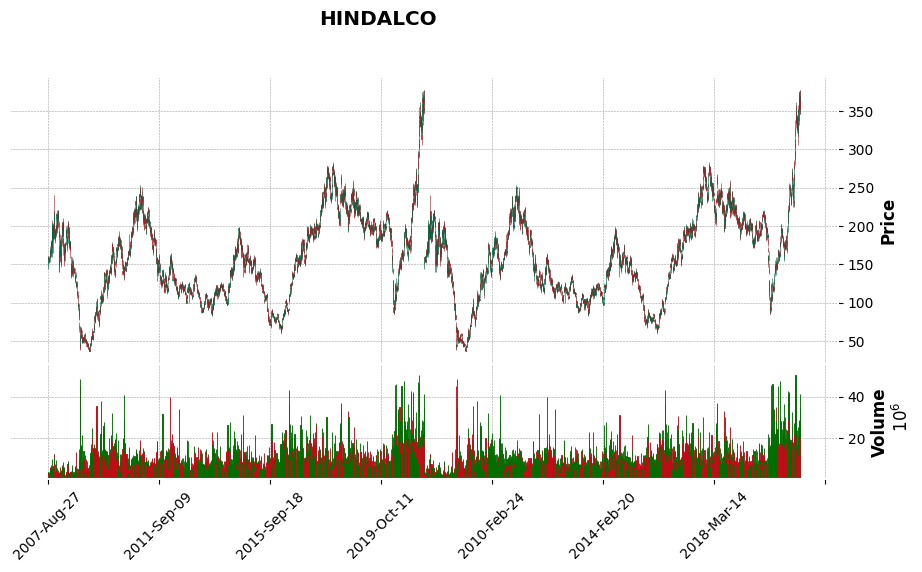

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


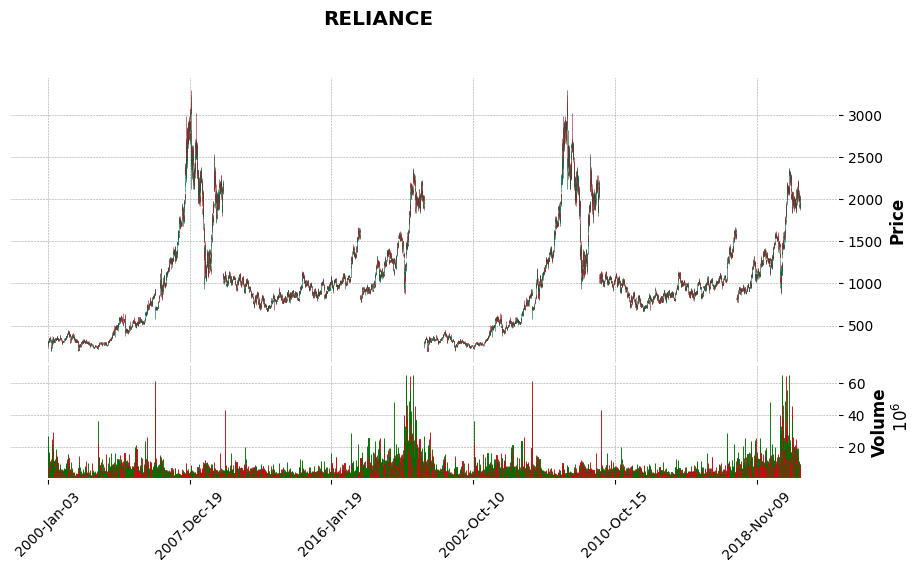

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


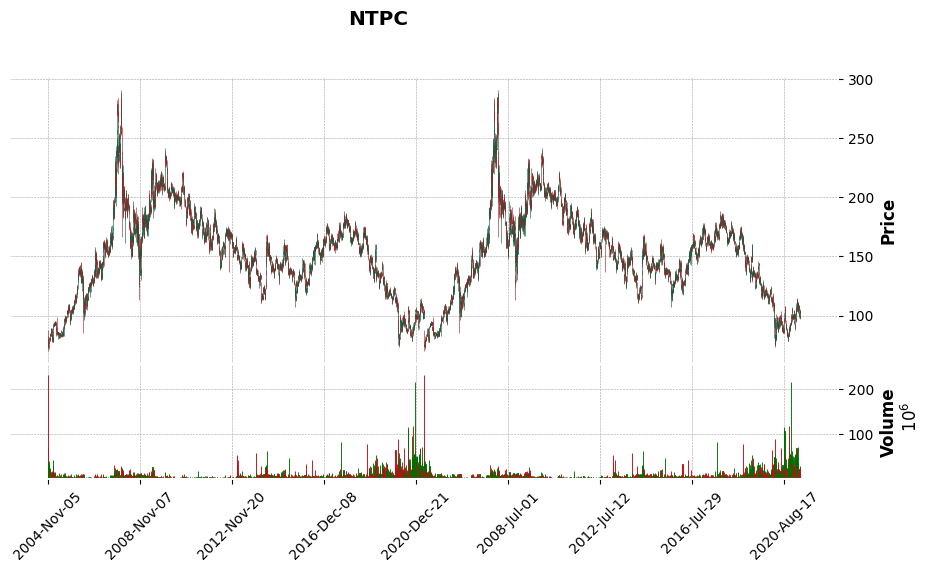

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


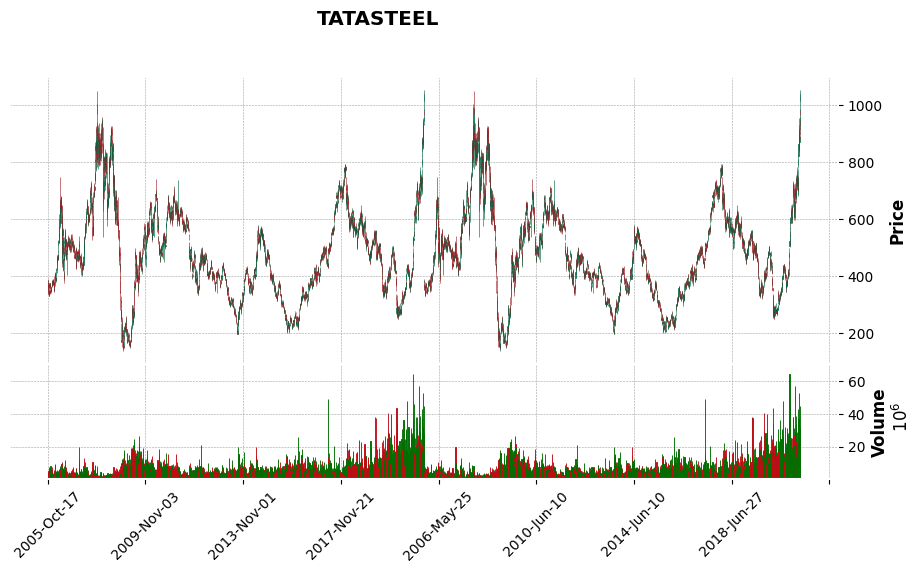

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


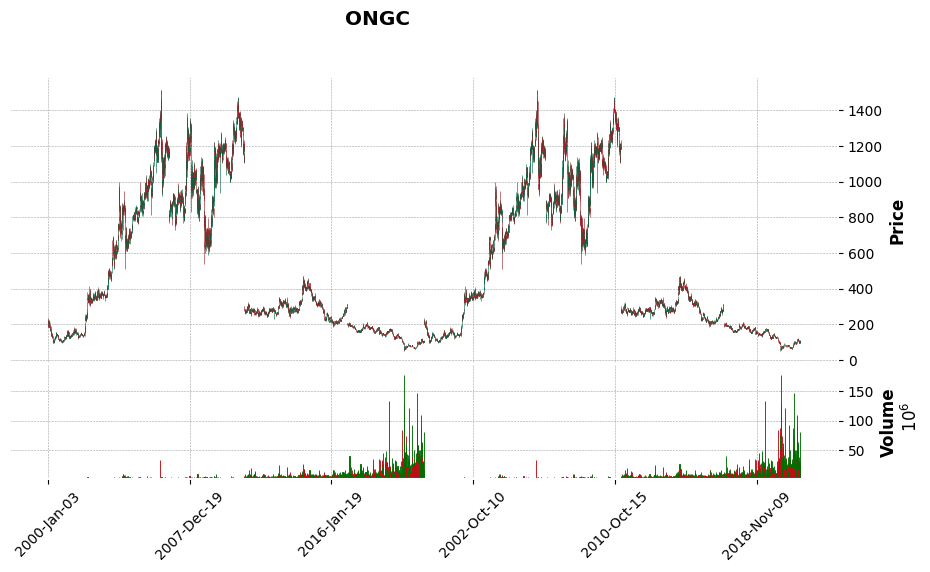

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


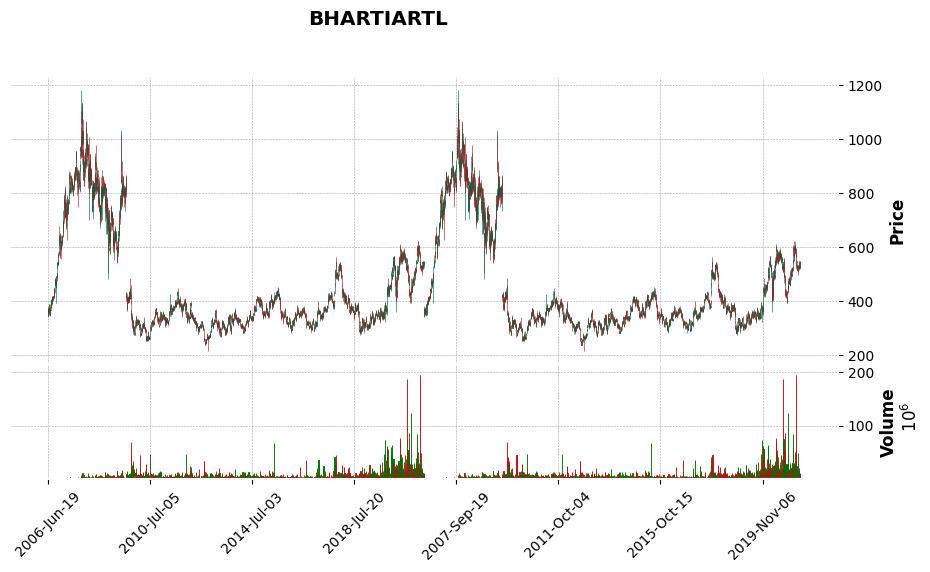

In [67]:
import zipfile
import pandas as pd
import mplfinance as mpf

# Step 1: Extract the data from the ZIP file
zip_file_path = '/content/archive.zip'  # Replace with your actual path

# List to store extracted data
dataframes = []

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all files to a temporary directory (or read directly)
    for file_info in zip_ref.infolist():
        if file_info.filename.endswith('.csv'):  # Adjust the file type if necessary
            with zip_ref.open(file_info.filename) as file:
                df = pd.read_csv(file)  # Load CSV into a DataFrame

                # Check if the DataFrame is not empty and has the required columns
                if not df.empty and all(col in df.columns for col in ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Symbol']):
                    dataframes.append(df)

# Concatenate all dataframes if there are multiple CSV files
data = pd.concat(dataframes, ignore_index=True)

# Step 2: Prepare the DataFrame
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # Ensure 'Date' is in datetime format, coerce errors
data.dropna(subset=['Date'], inplace=True)  # Drop rows where Date conversion failed
data.set_index('Date', inplace=True)  # Set Date as index for plotting

# Step 3: Define the top 10 symbols by trading volume
top_symbols = ['TATAMOTORS', 'SBIN', 'ICICIBANK', 'ITC', 'HINDALCO',
               'RELIANCE', 'NTPC', 'TATASTEEL', 'ONGC', 'BHARTIARTL']

# Step 4: Plot Candlestick Charts for each symbol
for symbol in top_symbols:
    symbol_data = data[data['Symbol'] == symbol]
    if not symbol_data.empty:  # Check if the symbol has data
        mpf.plot(symbol_data,
                  type='candle',
                  volume=True,
                  title=symbol,
                  style='charles',  # You can choose other styles like 'classic', 'yahoo', etc.
                  ylabel='Price',
                  ylabel_lower='Volume',
                  figratio=(12, 6))  # Aspect ratio of the figure


<ipython-input-70-986a890542c2>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat(dataframes, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

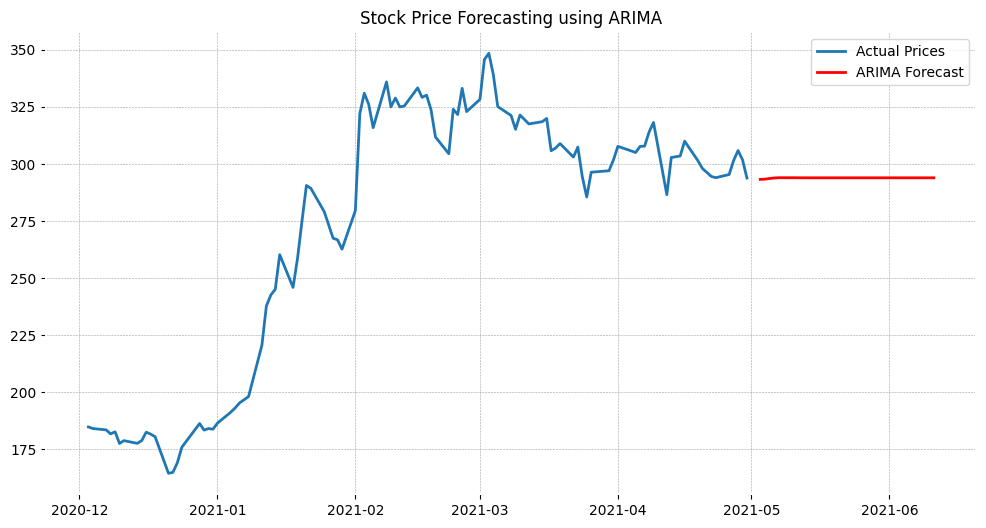

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - loss: 0.0165
Epoch 2/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - loss: 8.6154e-04
Epoch 3/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - loss: 5.3245e-04
Epoch 4/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - loss: 4.6373e-04
Epoch 5/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 3.9616e-04
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


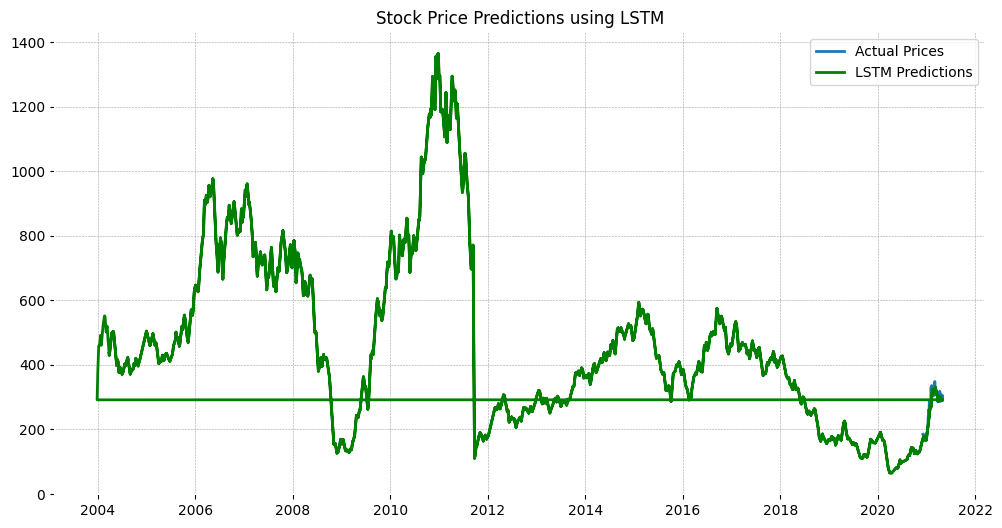

In [70]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Step 1: Extract the data from the ZIP file
zip_file_path = '/content/archive.zip'  # Replace with your actual path

# List to store extracted data
dataframes = []

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for file_info in zip_ref.infolist():
        if file_info.filename.endswith('.csv'):
            with zip_ref.open(file_info.filename) as file:
                df = pd.read_csv(file)

                # Check if the DataFrame has the required columns
                if 'Date' in df.columns and 'Close' in df.columns:
                    dataframes.append(df)

# Concatenate all dataframes
data = pd.concat(dataframes, ignore_index=True)

# Step 2: Prepare the DataFrame
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data.dropna(subset=['Date'], inplace=True)
data.set_index('Date', inplace=True)

# Choose a specific symbol for forecasting (e.g., TATAMOTORS)
symbol_data = data[data['Symbol'] == 'TATAMOTORS']
if symbol_data.empty:
    raise ValueError("No data found for the specified symbol.")

# Use only the 'Close' prices for forecasting
stock_data = symbol_data['Close']

# ARIMA Model
# Step 3: ARIMA forecasting
model_arima = ARIMA(stock_data, order=(5, 1, 0))  # p=5, d=1, q=0
model_fit_arima = model_arima.fit()

# Forecast future stock prices
forecast_steps = 30  # Forecasting 30 days ahead
forecast_arima = model_fit_arima.forecast(steps=forecast_steps)

# Plot ARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(stock_data[-100:], label="Actual Prices")
plt.plot(pd.date_range(stock_data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B'), forecast_arima, label="ARIMA Forecast", color='red')
plt.title("Stock Price Forecasting using ARIMA")
plt.legend()
plt.show()

# LSTM Model
# Step 4: Prepare data for LSTM
data_scaled = stock_data.values.reshape(-1, 1)  # Reshape for scaling

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_scaled)

# Create time series sequences
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60  # Using the previous 60 days to predict the next price
X, Y = create_dataset(data_scaled, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Step 5: Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dense(25))
model_lstm.add(Dense(1))

# Step 6: Compile and train the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X, Y, epochs=5, batch_size=32)

# Step 7: Make predictions with LSTM
train_predict = model_lstm.predict(X)

# Inverse transform predictions to original scale
train_predict = scaler.inverse_transform(train_predict)

# Plot LSTM predictions
plt.figure(figsize=(12, 6))
plt.plot(stock_data[-100:], label="Actual Prices")
plt.plot(stock_data.index[time_step:len(train_predict) + time_step], train_predict, label="LSTM Predictions", color='green')
plt.title("Stock Price Predictions using LSTM")
plt.legend()
plt.show()


<ipython-input-72-415d5af4b4a8>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat(dataframes, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

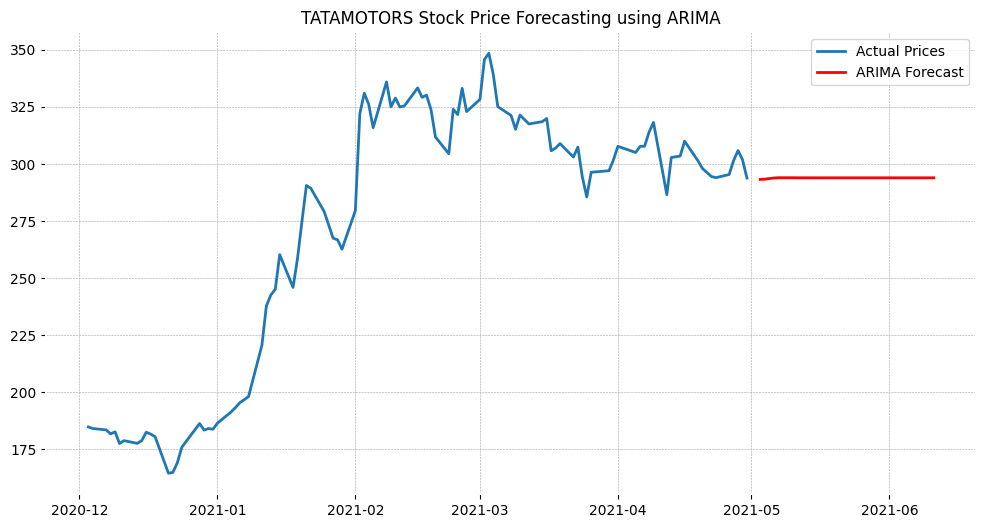

In [72]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Step 1: Extract the data from the ZIP file
zip_file_path = '/content/archive.zip'  # Replace with your actual path

# List to store extracted data
dataframes = []

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for file_info in zip_ref.infolist():
        if file_info.filename.endswith('.csv'):
            with zip_ref.open(file_info.filename) as file:
                df = pd.read_csv(file)

                # Check if the DataFrame has the required columns
                if 'Symbol' in df.columns and 'Date' in df.columns and 'Close' in df.columns:
                    dataframes.append(df)

# Concatenate all dataframes
data = pd.concat(dataframes, ignore_index=True)

# Step 2: Prepare the DataFrame
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data.dropna(subset=['Date'], inplace=True)
data.set_index('Date', inplace=True)

# Check for available symbols
available_symbols = data['Symbol'].unique()

# Choose a symbol for forecasting from available symbols (e.g., TATAMOTORS)
if 'TATAMOTORS' in available_symbols:
    symbol = 'TATAMOTORS'
else:
    symbol = available_symbols[0]  # Use the first available symbol if TATAMOTORS is not found
    print(f"'TATAMOTORS' not found. Using '{symbol}' instead.")

# Filter data for the chosen symbol
symbol_data = data[data['Symbol'] == symbol]

if symbol_data.empty:
    raise ValueError(f"No data found for the symbol: {symbol}")

# Use only the 'Close' prices for forecasting
stock_data = symbol_data['Close']

# ARIMA Model
# Step 3: ARIMA forecasting
model_arima = ARIMA(stock_data, order=(5, 1, 0))  # p=5, d=1, q=0
model_fit_arima = model_arima.fit()

# Forecast future stock prices
forecast_steps = 30  # Forecasting 30 days ahead
forecast_arima = model_fit_arima.forecast(steps=forecast_steps)

# Plot ARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(stock_data[-100:], label="Actual Prices")
plt.plot(pd.date_range(stock_data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B'), forecast_arima, label="ARIMA Forecast", color='red')
plt.title(f"{symbol} Stock Price Forecasting using ARIMA")
plt.legend()
plt.show()

# LSTM Model
# Step 4: Prepare data for LSTM
data_scaled = stock_data.values.reshape(-1, 1)  # Reshape for scaling

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_scaled)

# Create time series sequences
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60  # Using the previous 60 days to predict the next price
X, Y = create_dataset(data_scaled, time_step)

# Reshape input to be [samples, time steps,

<ipython-input-74-7f58a8f5e2ea>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat(dataframes, ignore_index=True)


Available Symbols: ['MUNDRAPORT' 'ADANIPORTS' 'ASIANPAINT' 'UTIBANK' 'AXISBANK' 'BAJAJ-AUTO'
 'BAJAJFINSV' 'BAJAUTOFIN' 'BAJFINANCE' 'BHARTI' 'BHARTIARTL' 'BPCL'
 'BRITANNIA' 'CIPLA' 'COALINDIA' 'DRREDDY' 'EICHERMOT' 'GAIL' 'GRASIM'
 'HCLTECH' 'HDFC' 'HDFCBANK' 'HEROHONDA' 'HEROMOTOCO' 'HINDALC0'
 'HINDALCO' 'HINDLEVER' 'HINDUNILVR' 'ICICIBANK' 'INDUSINDBK' 'INFOSYSTCH'
 'INFY' 'IOC' 'ITC' 'JSWSTL' 'JSWSTEEL' 'KOTAKMAH' 'KOTAKBANK' 'LT'
 'MARUTI' 'M&M' 'NESTLEIND' 'NTPC' 'ONGC' 'POWERGRID' 'RELIANCE' 'SBIN'
 'SHREECEM' 'SUNPHARMA' 'TELCO' 'TATAMOTORS' 'TISCO' 'TATASTEEL' 'TCS'
 'TECHM' 'TITAN' 'ULTRACEMCO' 'UNIPHOS' 'UPL' 'SESAGOA' 'SSLT' 'VEDL'
 'WIPRO' 'ZEETELE' 'ZEEL']
'FB' not found. Using 'MUNDRAPORT' instead.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

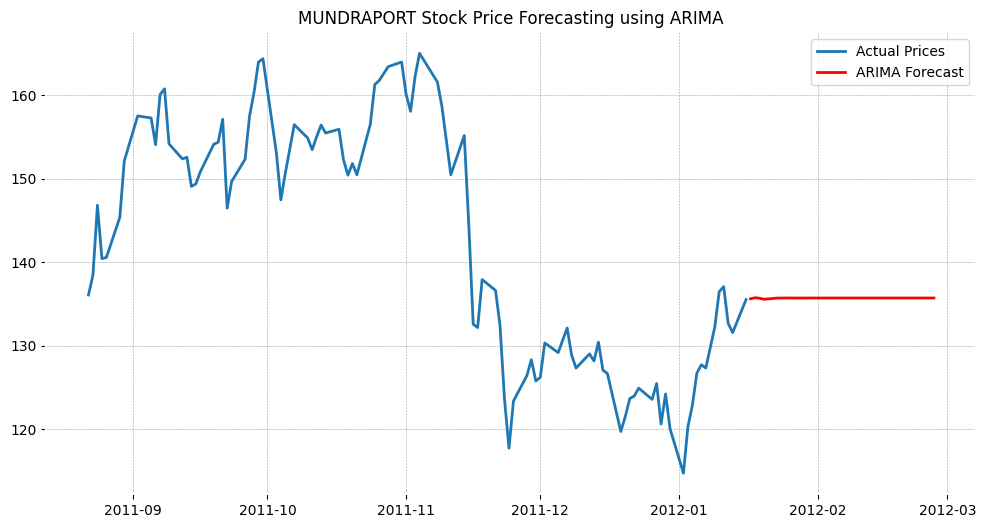

In [74]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Step 1: Extract the data from the ZIP file
zip_file_path = '/content/archive.zip'  # Replace with your actual path

# List to store extracted data
dataframes = []

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for file_info in zip_ref.infolist():
        if file_info.filename.endswith('.csv'):
            with zip_ref.open(file_info.filename) as file:
                df = pd.read_csv(file)

                # Check if the DataFrame has the required columns
                if 'Symbol' in df.columns and 'Date' in df.columns and 'Close' in df.columns:
                    dataframes.append(df)

# Concatenate all dataframes
data = pd.concat(dataframes, ignore_index=True)

# Step 2: Prepare the DataFrame for FB
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data.dropna(subset=['Date'], inplace=True)
data.set_index('Date', inplace=True)

# Check for available symbols
available_symbols = data['Symbol'].unique()

# Print available symbols to check if 'FB' exists
print(f"Available Symbols: {available_symbols}")

# Choose a symbol for forecasting from available symbols (e.g., TATAMOTORS)
if 'FB' in available_symbols:
    symbol = 'FB'
else:
    symbol = available_symbols[0]  # Use the first available symbol if FB is not found
    print(f"'FB' not found. Using '{symbol}' instead.")

# Filter data for the chosen symbol
fb_data = data[data['Symbol'] == symbol]

if fb_data.empty:
    raise ValueError(f"No data found for {symbol}.")

# Use only the 'Close' prices for forecasting
stock_data = fb_data['Close']

# ARIMA Model
# Step 3: ARIMA forecasting
model_arima = ARIMA(stock_data, order=(5, 1, 0))  # p=5, d=1, q=0
model_fit_arima = model_arima.fit()

# Forecast future stock prices
forecast_steps = 30  # Forecasting 30 days ahead
forecast_arima = model_fit_arima.forecast(steps=forecast_steps)

# Plot ARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(stock_data[-100:], label="Actual Prices")
plt.plot(pd.date_range(stock_data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B'), forecast_arima, label="ARIMA Forecast", color='red')
plt.title(f"{symbol} Stock Price Forecasting using ARIMA")
plt.legend()
plt.show()

# LSTM Model
# Step 4: Prepare data for LSTM
data_scaled = stock_data.values.reshape(-1, 1)  # Reshape for scaling

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_scaled)

# Create time series sequences
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60  # Using the previous 60 days to predict the next price
X, Y = create_dataset(data_scaled, time_step)

# Reshape input to be [samples, time

<ipython-input-75-0253e34ce4c5>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat(dataframes, ignore_index=True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=72350.642, Time=12.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=72383.590, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=72365.616, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=72364.889, Time=1.53 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=72381.599, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=72356.592, Time=9.96 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=72354.867, Time=7.02 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=72335.013, Time=23.49 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=72353.608, Time=7.33 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=72357.297, Time=10.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=31.02 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=72336.066, Time=22.86 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=72355.262, Time=14.75 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=30.86 sec
 ARIMA(3,1,2)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


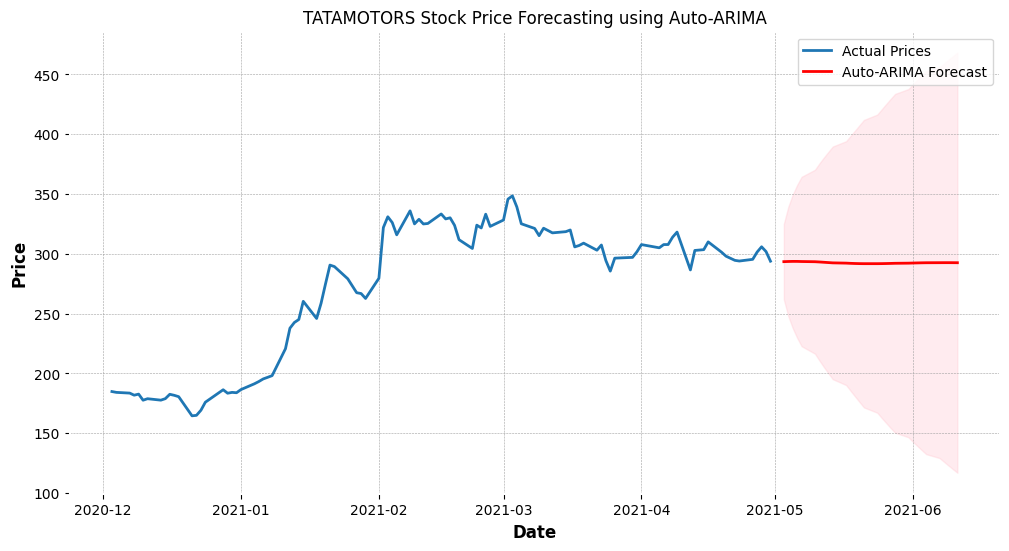

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=111355.305, Time=25.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=111407.489, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=111382.764, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=111382.274, Time=1.76 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=111405.489, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=111370.934, Time=13.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=111368.125, Time=18.59 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=111361.847, Time=18.83 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=111362.347, Time=7.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=111384.153, Time=4.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=111360.351, Time=2.91 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=111360.071, Time=10.64 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=111359.233, Time=34.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=111353.313, Time=7.85 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


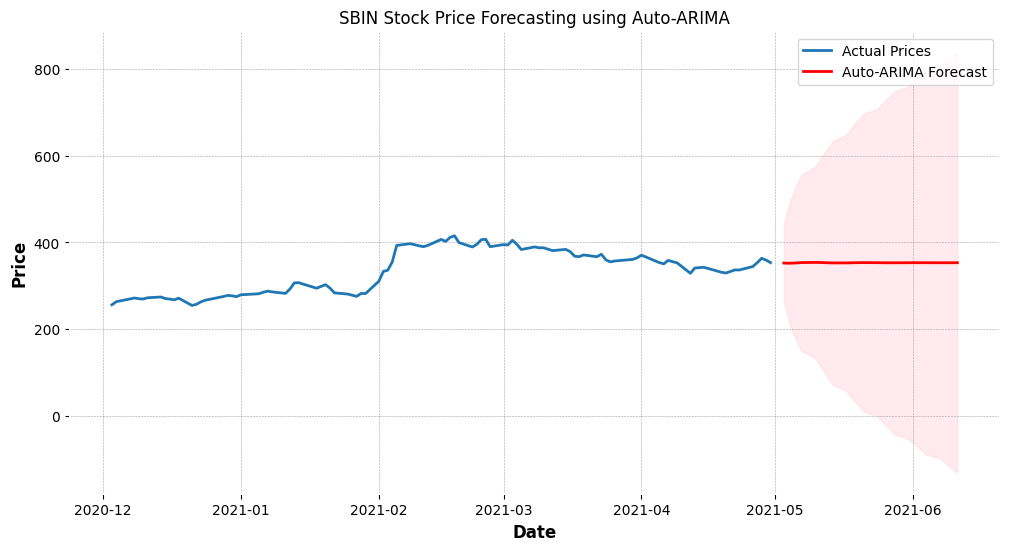

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=98960.076, Time=19.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=98971.747, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=98965.600, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=98965.382, Time=1.82 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=98969.786, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=98957.907, Time=17.97 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=98965.746, Time=3.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=98966.739, Time=3.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=98958.820, Time=19.32 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=98964.392, Time=2.98 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=98957.574, Time=16.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=98965.544, Time=1.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=98958.612, Time=22.01 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=98964.360, Time=2.18 sec
 ARIMA(3,1,2)(

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


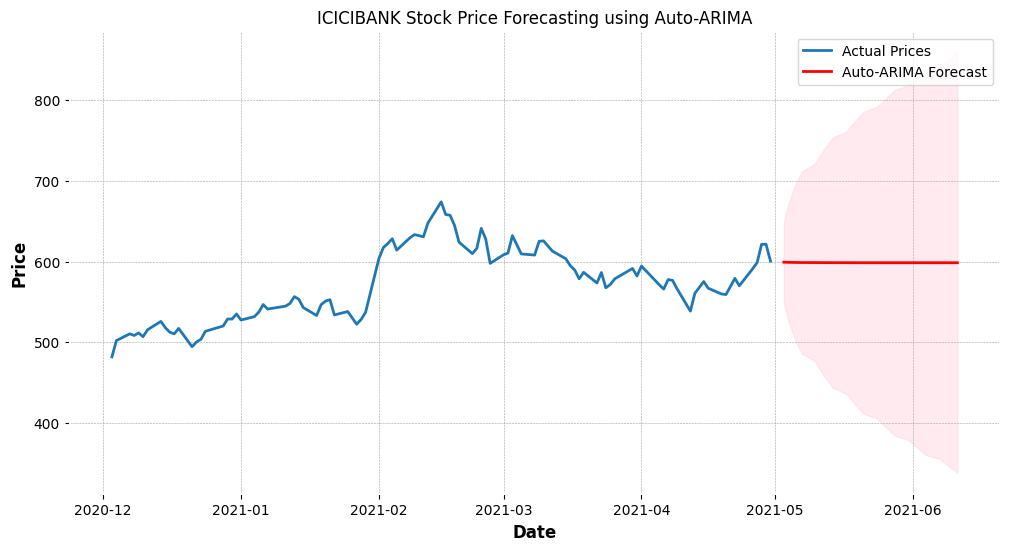

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=100310.377, Time=10.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=100316.438, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=100317.340, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=100317.269, Time=3.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=100314.470, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=100308.825, Time=15.96 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=100309.390, Time=2.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=100309.447, Time=9.79 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=100312.465, Time=3.46 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=100310.581, Time=2.98 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=100308.906, Time=14.98 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=100312.344, Time=32.40 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=100306.851, Time=5.74 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=100307.419, Time=0.64 sec
 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


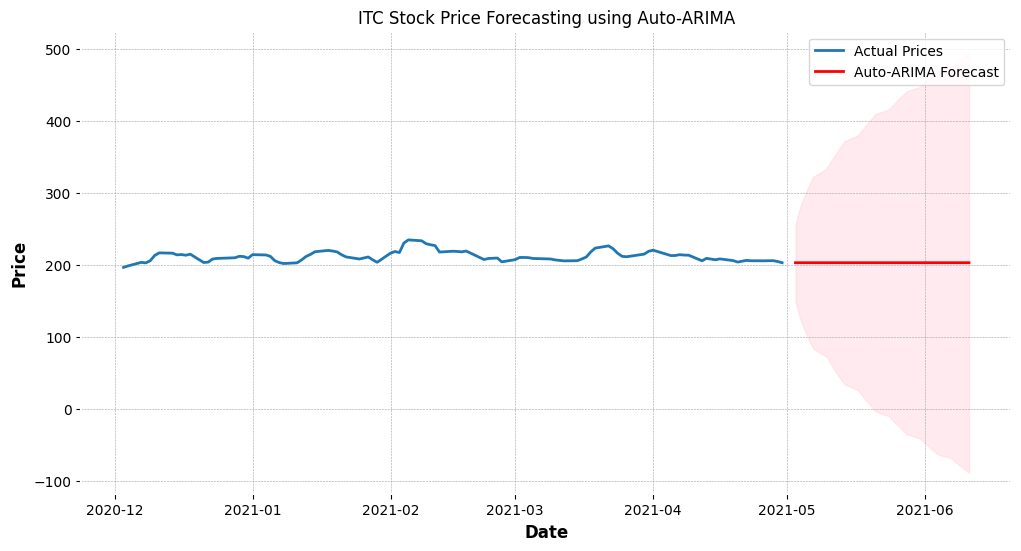

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=41362.958, Time=9.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41362.764, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41364.609, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=41364.604, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=41361.025, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=41363.678, Time=5.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 16.655 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


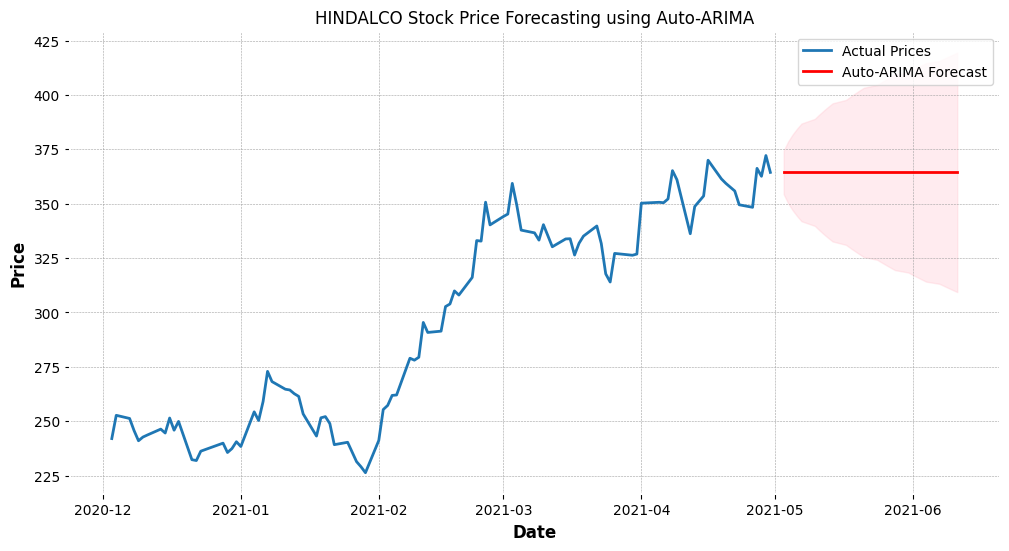

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=106946.921, Time=21.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=107005.581, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=107001.220, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=107001.181, Time=1.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=107003.786, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=106985.673, Time=10.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=106983.061, Time=18.67 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=106946.769, Time=29.99 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=106959.733, Time=17.51 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=106948.748, Time=49.23 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=106948.578, Time=24.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=106946.755, Time=31.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=106963.195, Time=14.94 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=106948.696, Time=46.22

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


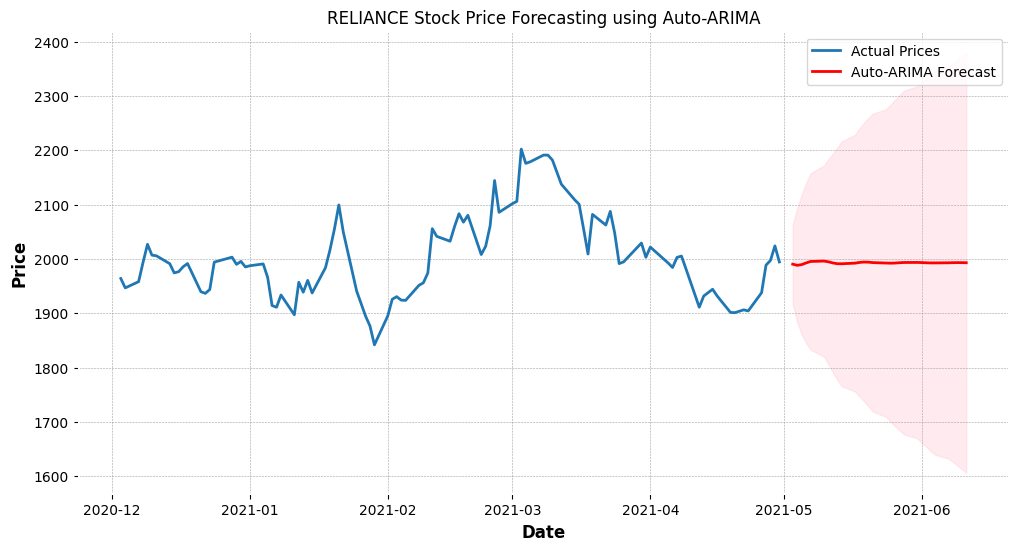

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=41454.707, Time=9.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41479.091, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41481.032, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=41481.028, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=41477.100, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=41453.296, Time=6.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=41474.943, Time=1.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=41453.711, Time=7.41 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=41454.315, Time=8.85 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=41472.335, Time=4.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=41453.361, Time=7.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=22.99 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=41451.315, Time=3.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=41472.953, Time=0.66 sec
 ARIMA(1,1,1)(0,0,0)[0] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


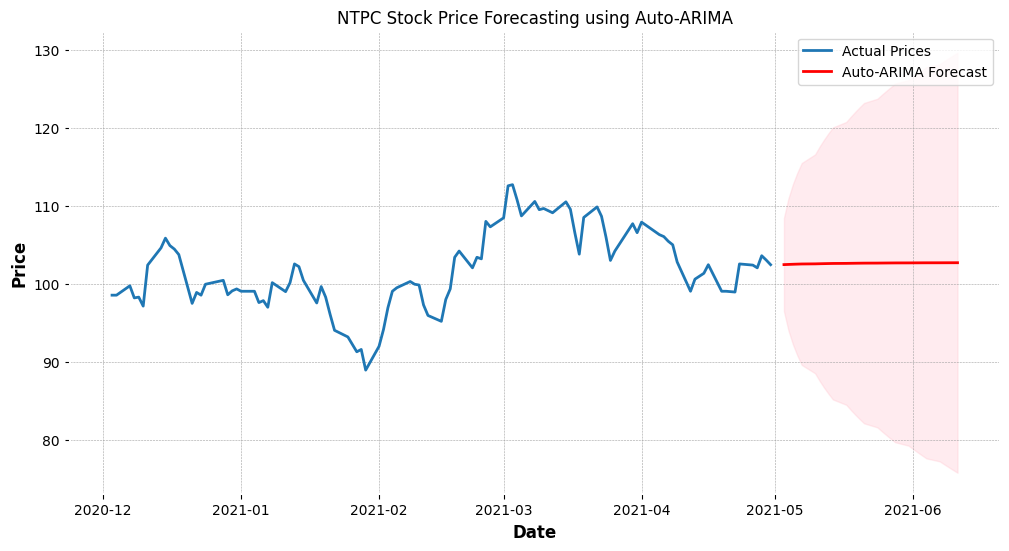

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=63634.883, Time=15.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=63633.536, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=63631.177, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=63631.121, Time=2.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63631.778, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=63631.167, Time=6.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=63632.816, Time=1.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=63633.947, Time=7.84 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=63629.351, Time=1.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=63629.402, Time=2.62 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=63631.049, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=63629.407, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=63632.950, Time=0.61 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 37.941 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


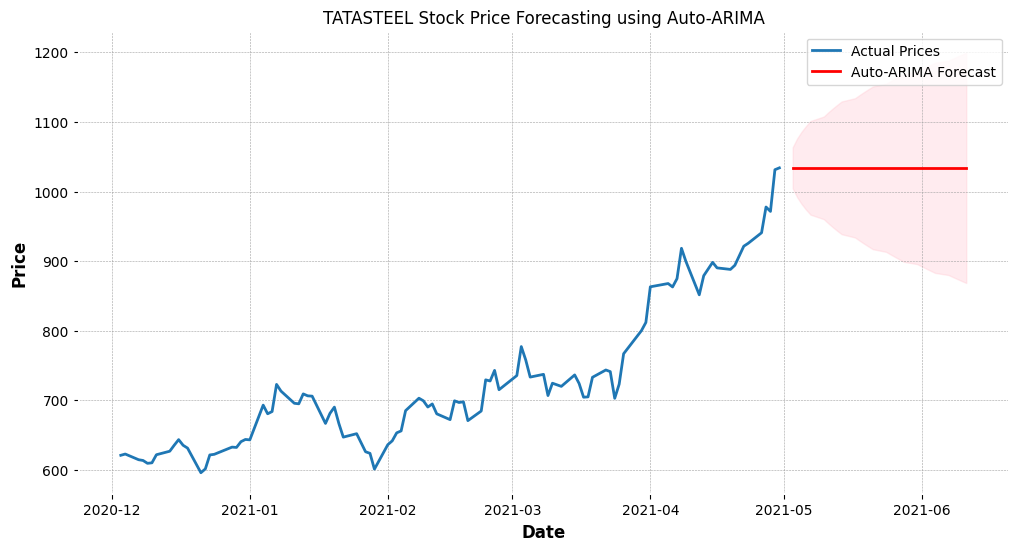

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=93225.100, Time=35.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=93256.575, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=93252.024, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=93251.892, Time=2.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=93254.578, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=93247.931, Time=16.67 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=93247.512, Time=20.53 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=93249.213, Time=33.08 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=93249.208, Time=38.60 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=93253.650, Time=2.75 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=93248.230, Time=15.64 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=93253.040, Time=2.56 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=93250.145, Time=25.44 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=93223.121, Time=6.53 sec
 ARIMA(1,1,2

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


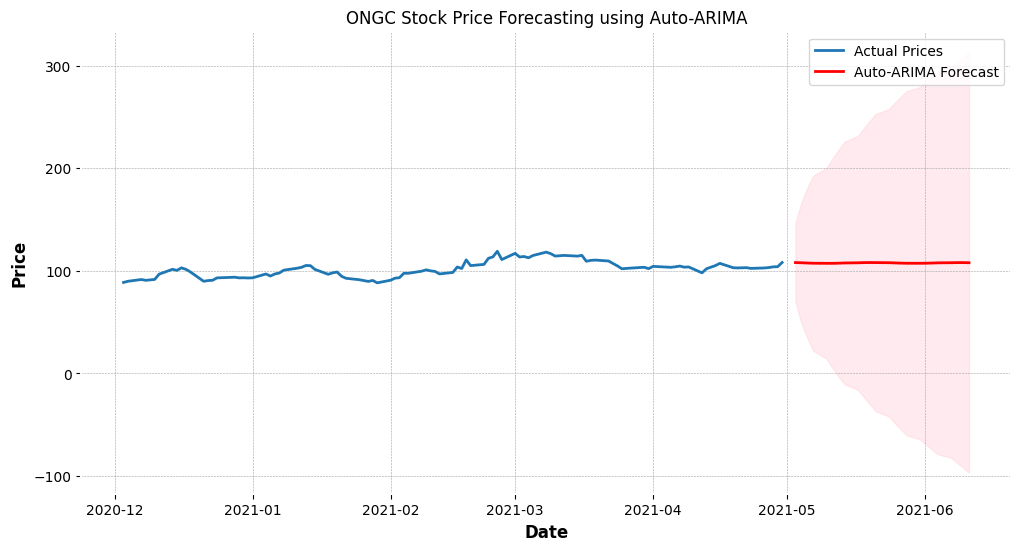

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=59903.981, Time=6.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=59944.952, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=59946.244, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=59946.140, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=59942.973, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=59902.292, Time=7.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=59916.948, Time=1.73 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=59915.561, Time=2.83 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=59903.922, Time=9.79 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=59910.008, Time=2.92 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=59902.763, Time=4.81 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=59905.919, Time=23.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=59900.322, Time=1.81 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=59914.973, Time=0.80 sec
 ARIMA(1,1,1)(0,0,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


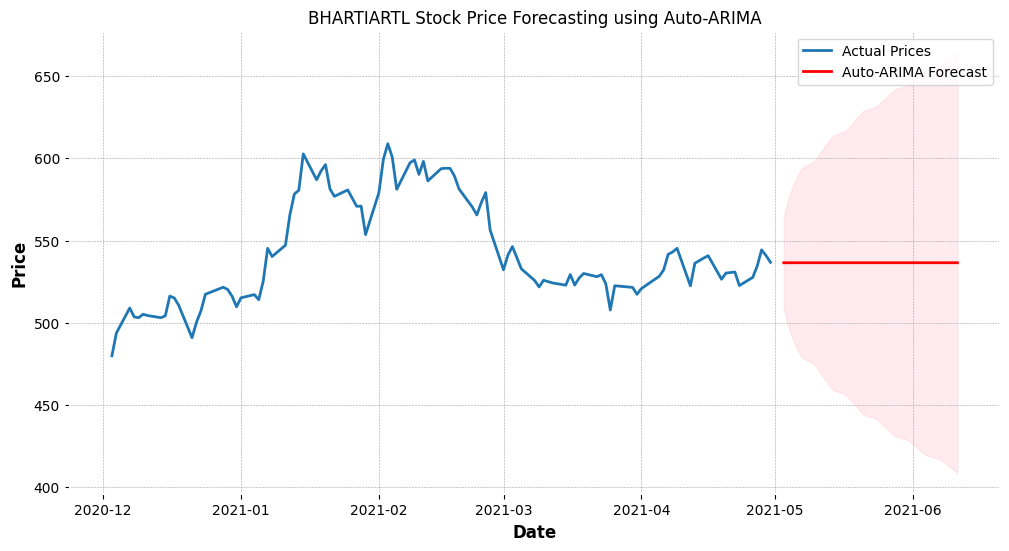

In [75]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Step 1: Extract the data from the ZIP file
zip_file_path = '/content/archive.zip'  # Replace with your actual path

# List to store extracted data
dataframes = []

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for file_info in zip_ref.infolist():
        if file_info.filename.endswith('.csv'):
            with zip_ref.open(file_info.filename) as file:
                df = pd.read_csv(file)

                # Check if the DataFrame has the required columns
                if 'Symbol' in df.columns and 'Date' in df.columns and 'Close' in df.columns:
                    dataframes.append(df)

# Concatenate all dataframes
data = pd.concat(dataframes, ignore_index=True)

# Step 2: Prepare the DataFrame for the top 10 symbols
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data.dropna(subset=['Date'], inplace=True)
data.set_index('Date', inplace=True)

# Top 10 symbols based on total volume (as previously listed)
top_10_symbols = [
    'TATAMOTORS',
    'SBIN',
    'ICICIBANK',
    'ITC',
    'HINDALCO',
    'RELIANCE',
    'NTPC',
    'TATASTEEL',
    'ONGC',
    'BHARTIARTL'
]

# Step 3: Auto-ARIMA forecasting for each symbol
for symbol in top_10_symbols:
    symbol_data = data[data['Symbol'] == symbol]

    if symbol_data.empty:
        print(f"No data found for {symbol}.")
        continue

    # Use only the 'Close' prices for forecasting
    stock_data = symbol_data['Close'].dropna()

    # Fit Auto-ARIMA model
    model = auto_arima(stock_data, seasonal=False, stepwise=True, trace=True)

    # Forecast future stock prices
    forecast_steps = 30  # Forecasting 30 days ahead
    forecast, conf_int = model.predict(n_periods=forecast_steps, return_conf_int=True)

    # Create index for forecasted dates
    forecast_index = pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data[-100:], label="Actual Prices")
    plt.plot(forecast_index, forecast, label="Auto-ARIMA Forecast", color='red')
    plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
    plt.title(f"{symbol} Stock Price Forecasting using Auto-ARIMA")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
